# Dependencies and files

## Imports

In [1]:
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import gseapy
import os
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Global variables

## Load files

### Load clusters

Load clusters for human-specific genes

In [2]:
cluster_groups = pd.read_csv('../../Specie-specific genes/results/human_clusters_edgeR_6.csv', index_col=0)
cluster_groups.columns = ['label']
cluster_groups.head()

label
LPL          0
SCN3B        0
RGS2         0
KIF21B       0
ST3GAL5      0

Load human/age-specific genes

In [3]:
hs_groups = pd.read_csv('../../Specie-specific genes/results/age_hs_groups.csv', index_col=0)
hs_groups.head()

label
LDHB     age-specific
NRXN2    age-specific
NDUFB10  age-specific
ZBTB46   age-specific
ASAP2    age-specific

In [4]:
human_specific_genes = cluster_groups.index.to_list()
human_specific_genes[:5]

['LPL', 'SCN3B', 'RGS2', 'KIF21B', 'ST3GAL5']

### Load EdgeR results

In [5]:
dirpath = 'results/DE'
res_edgeR = dict()

for file in os.listdir(dirpath):
    # read celltype name
    celltype = file.rstrip('.csv').lstrip('degenes_')
    # read DE results to DataFrame
    df = pd.read_csv(f'{dirpath}/{file}', index_col=0).reset_index(names='names')
    # add a direction to the F-score
    df['score'] =  np.log1p(df['F'] * np.heaviside(df['F'], 0)) * np.sign(df['logFC'])
    # save to the dict
    res_edgeR[celltype] = df

res_edgeR.keys()

dict_keys(['AST', 'ExNeu', 'GLIALPROG', 'IN', 'MG', 'OL', 'OPC', 'VASC'])

In [6]:
res_edgeR['AST'].head()

names     logFC     logCPM            F         PValue            FDR  \
0   LRIG1  3.298616   9.496065  1360.099108  1.152664e-148  1.767265e-144   
1  SLC1A2  3.529213   9.984837  1086.120068  8.184709e-140  6.274398e-136   
2   DCLK2  2.515757  10.104979   885.759289  1.037684e-118  5.303258e-115   
3    RFX4  3.581270   9.298022   880.548043  5.831319e-111  2.235145e-107   
4    DTNA  2.349995   9.880736   695.934434  5.918155e-104  1.814743e-100   

      score  
0  7.216048  
1  6.991287  
2  6.787574  
3  6.781680  
4  6.546691

### Load chimp-specific genes

Load clusters for chimp-specific genes

In [8]:
chimp_cluster_groups = pd.read_csv('../../Specie-specific genes/results/chimp_clusters_edgeR_4.csv', index_col=0)
chimp_cluster_groups.columns = ['label']
chimp_cluster_groups.head()

label
ANK3         0
BCL6         0
RIPOR2       0
TPD52L1      0
ARF5         1

In [9]:
chimp_specific_genes = chimp_cluster_groups.index.to_list()
chimp_specific_genes[:5]

['ANK3', 'BCL6', 'RIPOR2', 'TPD52L1', 'ARF5']

### Load pseudobulks

In [10]:
adata_pb = sc.read_h5ad('results/pb_adata_diffexpr.h5ad')
adata_pb

AnnData object with n_obs × n_vars = 383 × 11592
    obs: 'dataset', 'sample', 'individual', 'region', 'age', 'age(days)', 'age_range', 'sex_original', 'region_broad', 'chemistry', 'PMI', 'sex', 'lineage', 'psbulk_n_cells', 'psbulk_counts'
    var: 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'age_range_colors', 'dataset_colors', 'dendrogram_lineage', 'hvg', 'individual_colors', 'lineage_colors', 'log1p', 'logreg', 'neighbors', 'pca', 'region_colors', 't-test', 'umap', 'wilcoxon'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'psbulk_props'
    obsp: 'connectivities', 'distances'

Create celltypes list

In [11]:
celltypes = adata_pb.obs.lineage.unique().tolist()
celltypes

['AST', 'ExNeu', 'GLIALPROG', 'IN', 'MG', 'OL', 'OPC', 'VASC']

Scale pseudobulk data

In [12]:
genes = adata_pb.var_names.intersection(human_specific_genes + chimp_specific_genes)
scaled_adata_pb = sc.pp.scale(adata_pb[:, genes], copy=True)

### Load Velmeshev data

In [13]:
adata_velm = sc.read_h5ad('results/adata_velm_umap_ver2.h5ad')
adata_velm

AnnData object with n_obs × n_vars = 319893 × 20116
    obs: 'dataset', 'sample', 'individual', 'region', 'age', 'age(days)', 'age_range', 'sex_original', 'region_broad', 'chemistry', 'PMI', 'sex', 'seurat_clusters', 'lineage'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'age_colors', 'age_range_colors', 'dataset_colors', 'hvg', 'individual_colors', 'lineage_colors', 'log1p', 'neighbors', 'pca', 'region_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

Scale data for specie-specific genes

In [14]:
genes = adata_velm.var_names.intersection(human_specific_genes + chimp_specific_genes)
scaled_adata_list = list()

for sample in adata_velm.obs['individual'].unique():
    scaled_adata_list.append(sc.pp.scale(adata_velm[adata_velm.obs['individual'] == sample, genes], copy=True))

scaled_adata = an.concat(scaled_adata_list , merge='same',uns_merge="unique")
scaled_adata

AnnData object with n_obs × n_vars = 319893 × 75
    obs: 'dataset', 'sample', 'individual', 'region', 'age', 'age(days)', 'age_range', 'sex_original', 'region_broad', 'chemistry', 'PMI', 'sex', 'seurat_clusters', 'lineage'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

## Usefull functions

In [15]:
def create_rank_df(adata, group, key, gene_col='names', score_col='scores', lfc_col='logfoldchanges', method='score', pval_cutoff=None):
    """
    Creates a DataFrame with ranked genes based on the results of DE (differential expression) analysis
    """
    # read results for DE
    de_res = sc.get.rank_genes_groups_df(adata, group=group, key=key, pval_cutoff=pval_cutoff)
    de_res = de_res.set_index(gene_col)
    # choose a method to create ranked gene list based on DE results
    if method == 'score':
        score_values = de_res[score_col]
    elif method == 'lfc_product':
        score_values = de_res['logfoldchanges'].abs() * de_res[score_col]
    else:
        raise ValueError('No such method')
    # create df with ranked genes
    gene_rank_df = score_values.sort_values(ascending=False).to_frame()
    return gene_rank_df

In [16]:
def enrich_celltypes(celltypes, gene_sets, adata=None, key=None, gene_col='names', score_col='scores', lfc_col='logfoldchanges', method='score', pval_cutoff=None, gsea_kw=None):
    """
    Find enrichment of gene_sets`for ranked gene lists
    """
    # set gsea parameters
    gsea_standart_kw = {
        'threads': 4,
        'min_size': 0,
        'max_size': 1000,
        'permutation_num': 1000, # reduce number to speed up testing
        'outdir': None, # don't write to disk
        'seed': 4,
        'verbose': True}
    
    if gsea_kw:
        gsea_standart_kw.update(gsea_kw)

    celltype_list = celltypes if adata else celltypes.keys()

    # results list
    res_df_list = list()
    # enrichment for each celltype
    for celltype in tqdm(celltype_list):
        # create a DataFrame with ranked genes
        if adata:
            rank_df = create_rank_df(adata, group=celltype, key=key, gene_col=gene_col, score_col=score_col, lfc_col=lfc_col, method=method, pval_cutoff=pval_cutoff)
        else:
            rank_df = celltypes[celltype].set_index(gene_col)[score_col].sort_values(ascending=False).to_frame()
        # enrich gene_sets based on ranked genes list
        gsea_res = gseapy.prerank(rnk=rank_df, gene_sets=gene_sets, **gsea_standart_kw)
        # save enrichment results
        res_df = gsea_res.res2d
        res_df['celltype'] = celltype
        res_df_list.append(res_df)
    # create DataFrame with results
    enrich_res = pd.concat(res_df_list, axis=0)
    return enrich_res

In [17]:
def process_enrichment_df(enrich_df):
    """
    Process the DataFrame with enrichment results
    """
    # convert FDR to -log10(FDR)
    enrich_df['-log10(FDR)'] = -np.log10(enrich_df['FDR q-val'].astype(float) + 1e-3)
    # Add direction column
    enrich_df['direction'] = enrich_df['ES'].map(lambda x: 'enriched' if x > 0 else 'depleted')
    # add significance category column
    enrich_df['significant'] = enrich_df['FDR q-val'].map(lambda x: 'FDR < 0.05' if x < 0.05 else 'FDR >= 0.05')

In [18]:
def enrichment_plot(enrich_res, figsize=(7,9), dpi=100, xlabel='Enrichment score', **kw_scatterplot):
    # create figure object
    fig = plt.figure(figsize=figsize, dpi=dpi)

    # create scatterplot
    ax = sns.scatterplot(data=enrich_res.reset_index(), **kw_scatterplot)

    # modify label parameters
    ax.tick_params(labelsize=10)
    ax.legend(fontsize=15)
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel("", fontsize=10)
    ax.grid(False)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# Enrichment

## Enrichment for all human-specific genes

Create a dict with genesets

In [19]:
geneset = {'human-specific genes': cluster_groups.index.to_list()}

### T-test

Specify DE test

In [20]:
key = 't-test'

Run enrichment for genesets

In [21]:
enrich_df = enrich_celltypes(celltypes, geneset, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='score', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/8 [00:00<?, ?it/s]

2024-07-04 17:15:41,803 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:15:42,422 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:15:43,624 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:15:44,137 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:15:45,328 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:15:45,948 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  human-specific genes -0.265233 -0.942895  0.586517  0.586517   
0  prerank  human-specific genes  0.551343  2.119671       0.0       0.0   

  FWER p-val  Tag %  Gene %  \
0   0.586517  22/59  25.28%   
0        0.0  19/59  14.21%   

                                          Lead_genes celltype  
0  ZBTB46;GNAI1;PDE1A;NUAK1;DLGAP4;IGSF21;SCN3B;O...      AST  
0  PDE1A;SCN3B;ZBTB18;IGSF21;KIF21B;DLGAP4;PTPRK;...    ExNeu

Process enrichment results

In [22]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  human-specific genes -0.265233 -0.942895  0.586517  0.586517   
0  prerank  human-specific genes  0.551343  2.119671       0.0       0.0   

  FWER p-val  Tag %  Gene %  \
0   0.586517  22/59  25.28%   
0        0.0  19/59  14.21%   

                                          Lead_genes celltype  -log10(FDR)  \
0  ZBTB46;GNAI1;PDE1A;NUAK1;DLGAP4;IGSF21;SCN3B;O...      AST      0.23098   
0  PDE1A;SCN3B;ZBTB18;IGSF21;KIF21B;DLGAP4;PTPRK;...    ExNeu      3.00000   

  direction  significant  
0  depleted  FDR >= 0.05  
0  enriched   FDR < 0.05

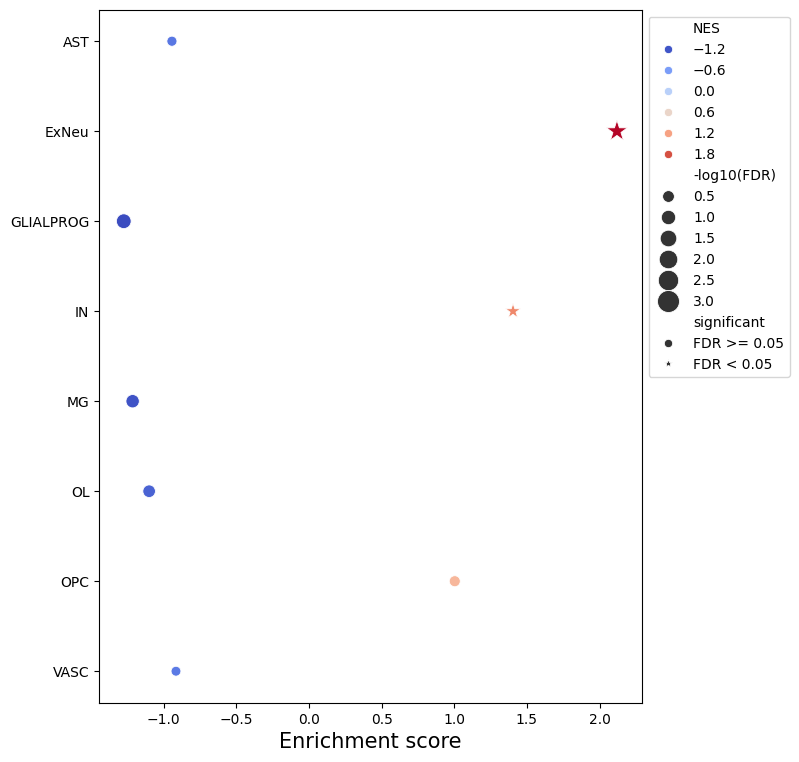

In [23]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='NES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

### Wilcoxon

Specify DE test

In [24]:
key = 'wilcoxon'

Run enrichment for genesets

In [25]:
enrich_df = enrich_celltypes(celltypes, geneset, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='lfc_product', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/8 [00:00<?, ?it/s]

2024-07-04 17:15:47,748 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:15:48,305 [WARNING] Duplicated values found in preranked stats: 0.04% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:15:48,813 [WARNING] Duplicated values found in preranked stats: 0.04% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:15:49,903 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:15:50,473 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  human-specific genes  0.422352     0.918  0.624843  0.624843   
0  prerank  human-specific genes  0.616357  1.491876   0.00569   0.00569   

  FWER p-val  Tag %  Gene %  \
0      0.498   9/59  13.35%   
0      0.004  19/59  17.28%   

                                          Lead_genes celltype  
0  ID2;LHX2;CHST10;NRXN1;MACF1;AMZ2;ASAP2;ALCAM;I...      AST  
0  PDE1A;SCN3B;IGSF21;ZBTB18;PTPRK;KIF21B;DLGAP4;...    ExNeu

Process enrichment results

In [26]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  human-specific genes  0.422352     0.918  0.624843  0.624843   
0  prerank  human-specific genes  0.616357  1.491876   0.00569   0.00569   

  FWER p-val  Tag %  Gene %  \
0      0.498   9/59  13.35%   
0      0.004  19/59  17.28%   

                                          Lead_genes celltype  -log10(FDR)  \
0  ID2;LHX2;CHST10;NRXN1;MACF1;AMZ2;ASAP2;ALCAM;I...      AST     0.203534   
0  PDE1A;SCN3B;IGSF21;ZBTB18;PTPRK;KIF21B;DLGAP4;...    ExNeu     2.174580   

  direction  significant  
0  enriched  FDR >= 0.05  
0  enriched   FDR < 0.05

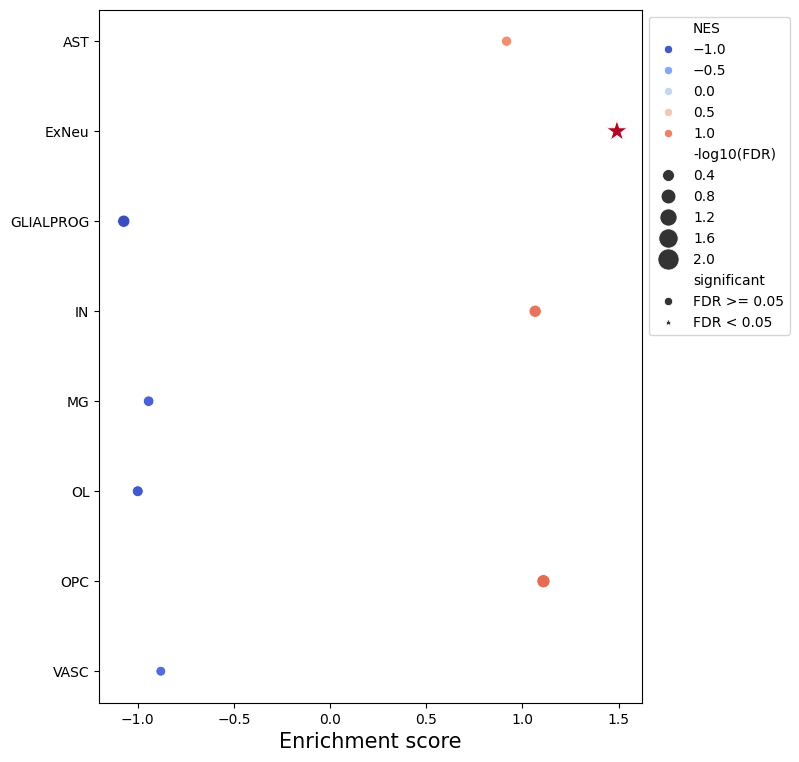

In [27]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='NES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

### Logreg

Specify DE test

In [28]:
key = 'logreg'

Run enrichment for genesets

In [29]:
enrich_df = enrich_celltypes(celltypes, geneset, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='score', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/8 [00:00<?, ?it/s]

2024-07-04 17:15:51,723 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:15:52,161 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:15:52,656 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:15:53,098 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:15:53,996 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  human-specific genes -0.335899 -1.154149  0.224806  0.224806   
0  prerank  human-specific genes  0.487916  1.594243  0.011792  0.011792   

  FWER p-val  Tag %  Gene %  \
0   0.224806  17/59  15.42%   
0      0.005  19/59  11.23%   

                                          Lead_genes celltype  
0  PDE1A;ZBTB46;VAT1L;CD47;KLHL2;PTPRK;SCN3B;OLA1...      AST  
0  PDE1A;IGSF21;ZBTB18;LHX2;PTPRK;KIF21B;SCN3B;DL...    ExNeu

Process enrichment results

In [30]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  human-specific genes -0.335899 -1.154149  0.224806  0.224806   
0  prerank  human-specific genes  0.487916  1.594243  0.011792  0.011792   

  FWER p-val  Tag %  Gene %  \
0   0.224806  17/59  15.42%   
0      0.005  19/59  11.23%   

                                          Lead_genes celltype  -log10(FDR)  \
0  PDE1A;ZBTB46;VAT1L;CD47;KLHL2;PTPRK;SCN3B;OLA1...      AST     0.646264   
0  PDE1A;IGSF21;ZBTB18;LHX2;PTPRK;KIF21B;SCN3B;DL...    ExNeu     1.893046   

  direction  significant  
0  depleted  FDR >= 0.05  
0  enriched   FDR < 0.05

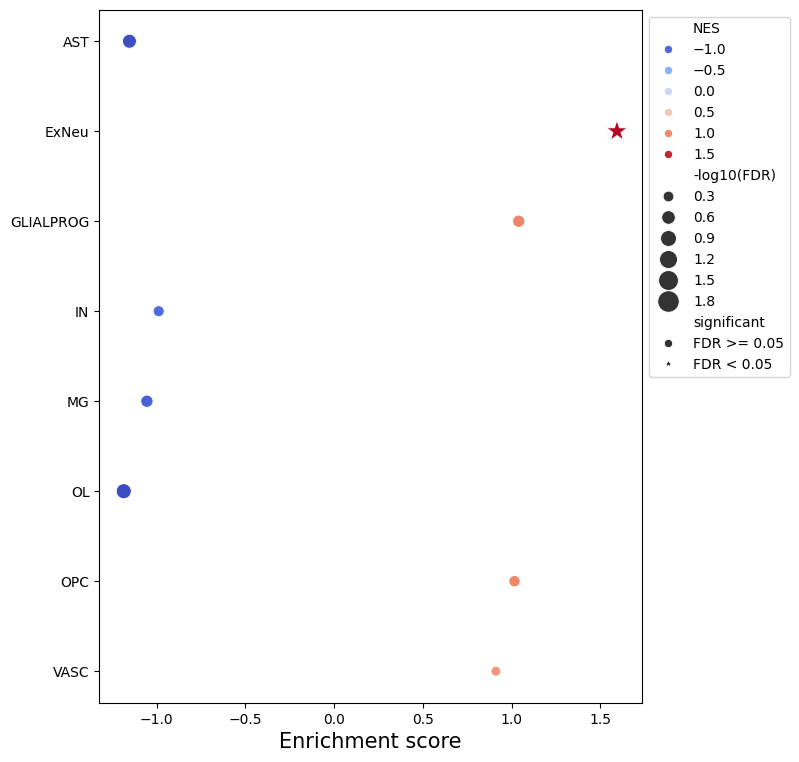

In [31]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='NES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

### EdgeR

Run enrichment for genesets

In [32]:
enrich_df = enrich_celltypes(res_edgeR, geneset, gene_col='names', score_col='score', method='score', gsea_kw={'verbose': True})
enrich_df.head(2)

  0%|          | 0/8 [00:00<?, ?it/s]

2024-07-04 17:15:55,876 [WARNING] Duplicated values found in preranked stats: 0.25% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:15:55,877 [INFO] Parsing data files for GSEA.............................
2024-07-04 17:15:55,881 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
2024-07-04 17:15:55,881 [INFO] 0001 gene_sets used for further statistical testing.....
2024-07-04 17:15:55,883 [INFO] Start to run GSEA...Might take a while..................
2024-07-04 17:15:56,779 [INFO] Congratulations. GSEApy runs successfully................

2024-07-04 17:15:56,796 [WARNING] Duplicated values found in preranked stats: 0.27% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:15:56,796 [INFO] Parsing data files for GSEA.............................
2024-07-04 17:15:56,796 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
20

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  human-specific genes  0.362398  0.869648  0.795569  0.795569   
0  prerank  human-specific genes  0.579935  1.531767       0.0       0.0   

  FWER p-val  Tag %  Gene %  \
0       0.79  16/60  24.15%   
0        0.0  42/60  31.12%   

                                          Lead_genes celltype  
0  ID2;MACF1;NRXN1;LHX2;ASAP2;CHST10;ALCAM;IGFBP2...      AST  
0  SCN3B;DLGAP4;PTPRK;ZBTB18;IGSF21;PDE1A;KIF21B;...    ExNeu

Process enrichment results

In [33]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  human-specific genes  0.362398  0.869648  0.795569  0.795569   
0  prerank  human-specific genes  0.579935  1.531767       0.0       0.0   

  FWER p-val  Tag %  Gene %  \
0       0.79  16/60  24.15%   
0        0.0  42/60  31.12%   

                                          Lead_genes celltype  -log10(FDR)  \
0  ID2;MACF1;NRXN1;LHX2;ASAP2;CHST10;ALCAM;IGFBP2...      AST     0.098777   
0  SCN3B;DLGAP4;PTPRK;ZBTB18;IGSF21;PDE1A;KIF21B;...    ExNeu     3.000000   

  direction  significant  
0  enriched  FDR >= 0.05  
0  enriched   FDR < 0.05

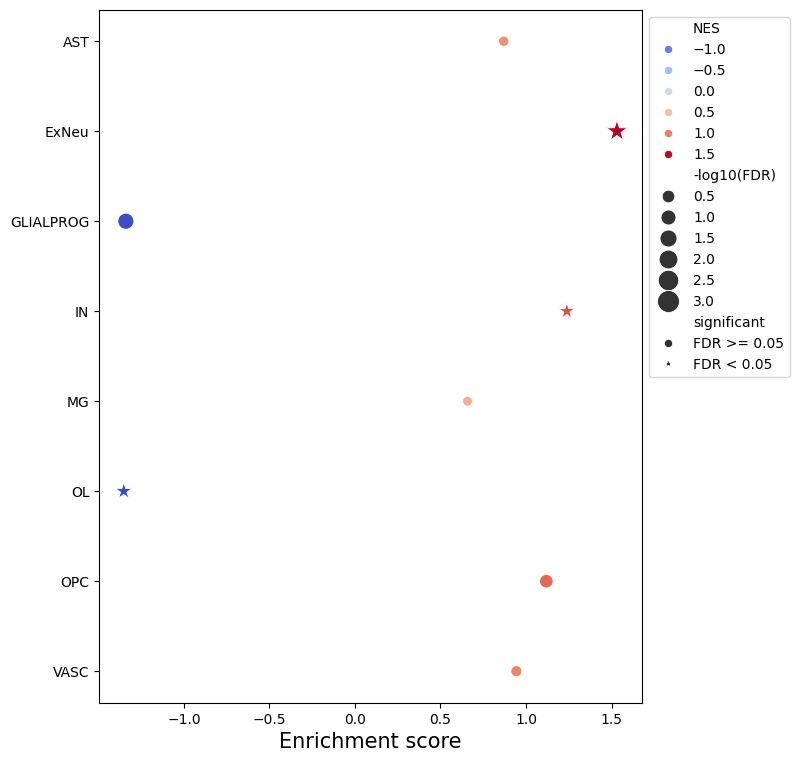

In [34]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='NES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

### Gene visualization

Calculate average normalized expression

In [35]:
genes = scaled_adata.var_names.intersection(human_specific_genes)
scaled_adata.obs[f'human_specific_scaled'] = scaled_adata[:, genes].X.mean(axis=1)
scaled_adata.obs.head()

dataset    sample individual region  \
cell                                                                     
U01_AAACCTGAGGCGATAC-1_4350_BA9  Velmeshev  4350_BA9       4350    BA9   
U01_AAACCTGAGTACACCT-1_4350_BA9  Velmeshev  4350_BA9       4350    BA9   
U01_AAACCTGCAGCTGGCT-1_4350_BA9  Velmeshev  4350_BA9       4350    BA9   
U01_AAACCTGCAGTAGAGC-1_4350_BA9  Velmeshev  4350_BA9       4350    BA9   
U01_AAACCTGGTCTAAACC-1_4350_BA9  Velmeshev  4350_BA9       4350    BA9   

                                      age age(days)  age_range sex_original  \
cell                                                                          
U01_AAACCTGAGGCGATAC-1_4350_BA9  196 days     462.0  0-1 years         Male   
U01_AAACCTGAGTACACCT-1_4350_BA9  196 days     462.0  0-1 years         Male   
U01_AAACCTGCAGCTGGCT-1_4350_BA9  196 days     462.0  0-1 years         Male   
U01_AAACCTGCAGTAGAGC-1_4350_BA9  196 days     462.0  0-1 years         Male   
U01_AAACCTGGTCTAAACC-1_4350_BA9  196 days     462.0  0-1 years         Male   

                                region_broad chemistry PMI   sex  \
cell                                                               
U01_AAACCTGAGGCGATAC-1_4350_BA9           FC        V2  20  Male   
U01_AAACCTGAGTACACCT-1_4350_BA9           FC        V2  20  Male   
U01_AAACCTGCAGCTGGCT-1_4350_BA9           FC        V2  20  Male   
U01_AAACCTGCAGTAGAGC-1_4350_BA9           FC        V2  20  Male   
U01_AAACCTGGTCTAAACC-1_4350_BA9           FC        V2  20  Male   

                                seurat_clusters lineage  human_specific_scaled  
cell                                                                            
U01_AAACCTGAGGCGATAC-1_4350_BA9              20   ExNeu               0.242244  
U01_AAACCTGAGTACACCT-1_4350_BA9              17   ExNeu              -0.072817  
U01_AAACCTGCAGCTGGCT-1_4350_BA9              10      IN              -0.034043  
U01_AAACCTGCAGTAGAGC-1_4350_BA9              21   ExNeu               0.531282  
U01_AAACCTGGTCTAAACC-1_4350_BA9              10      IN               0.006879

Vusualize

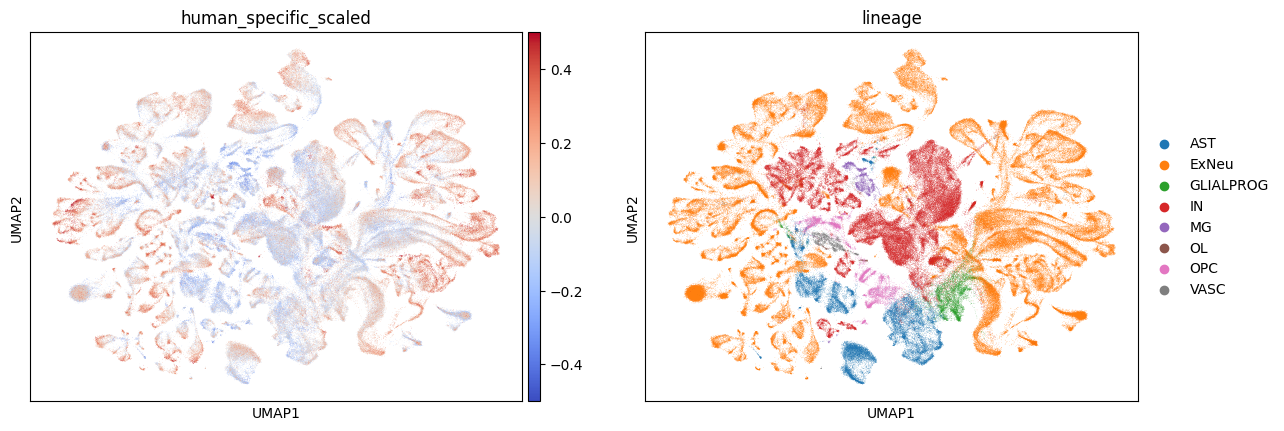

In [57]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmax=0.5, vmin=-0.5)

sc.pl.umap(scaled_adata, color=['human_specific_scaled', 'lineage'], cmap=cmap, norm=norm)

## Enrich for HS/AS groups

Create geneset dict

In [58]:
gene_sets = dict()
for label in hs_groups.label.unique():
  gene_sets[label] = hs_groups[hs_groups.label == label].index.to_list()

### T-test

Specify DE test

In [59]:
key = 't-test'

Run enrichment for genesets

In [60]:
enrich_df = enrich_celltypes(celltypes, gene_sets, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='score', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/8 [00:00<?, ?it/s]

2024-07-04 17:18:01,821 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:18:02,405 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:18:03,484 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:18:04,190 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:18:05,296 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:18:05,857 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be

Name                Term        ES       NES NOM p-val FDR q-val  \
0  prerank  maybe age-specific  0.527655  1.310034  0.132727    0.2723   
1  prerank        age-specific -0.412707 -1.231453  0.181425  0.413904   

  FWER p-val Tag % Gene %                 Lead_genes celltype  
0      0.253  3/15  2.74%             MACF1;LHX2;ID2      AST  
1   0.361538  4/26  6.25%  ZBTB46;GNAI1;PDE1A;DLGAP4      AST

Process enrichment results

In [61]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                Term        ES       NES NOM p-val FDR q-val  \
0  prerank  maybe age-specific  0.527655  1.310034  0.132727    0.2723   
1  prerank        age-specific -0.412707 -1.231453  0.181425  0.413904   

  FWER p-val Tag % Gene %                 Lead_genes celltype  -log10(FDR)  \
0      0.253  3/15  2.74%             MACF1;LHX2;ID2      AST     0.563360   
1   0.361538  4/26  6.25%  ZBTB46;GNAI1;PDE1A;DLGAP4      AST     0.382053   

  direction  significant  
0  enriched  FDR >= 0.05  
1  depleted  FDR >= 0.05

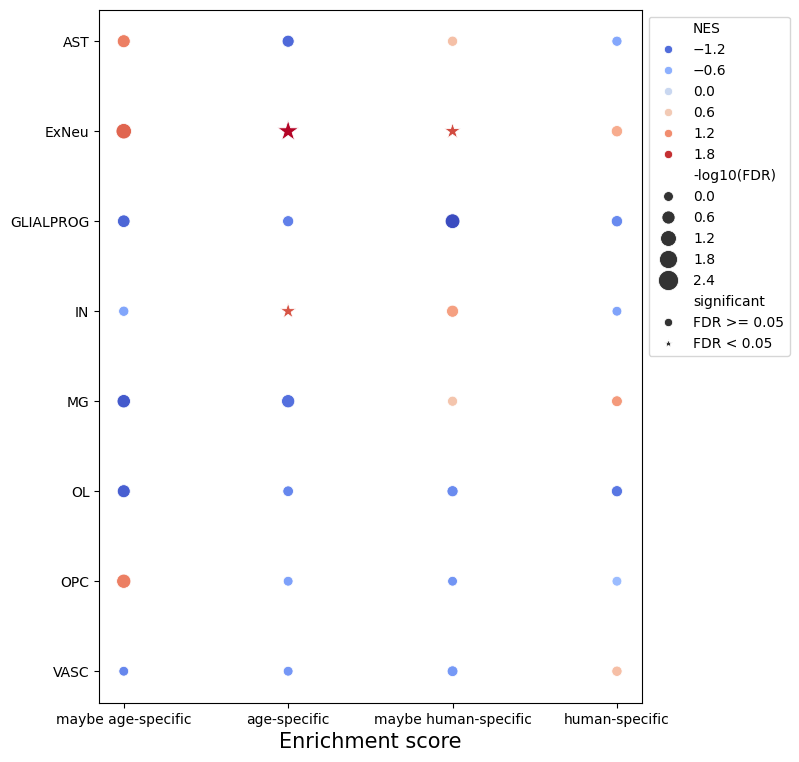

In [62]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='Term',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

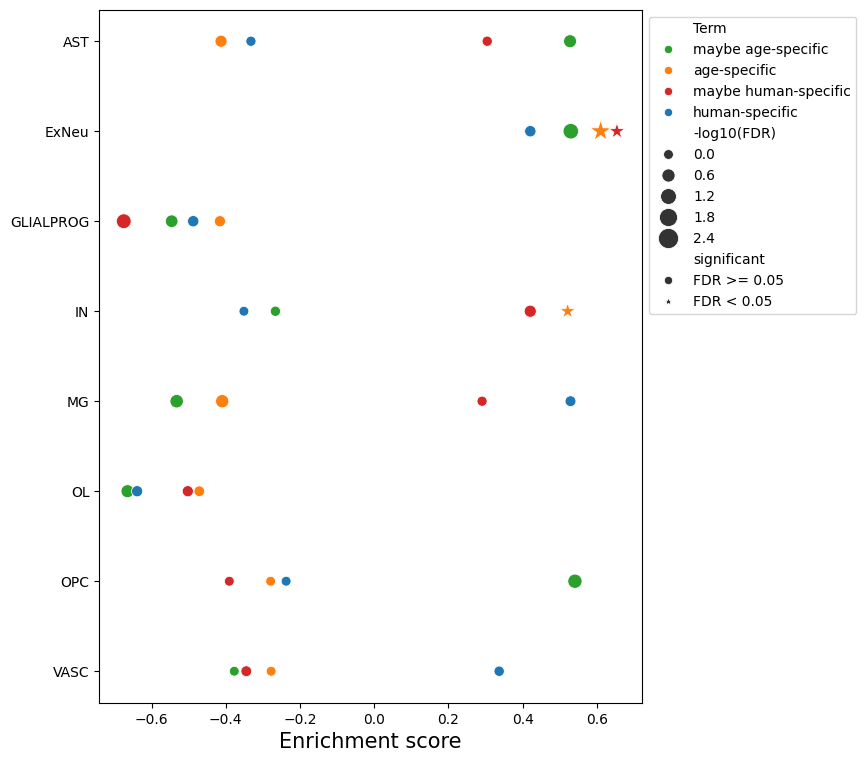

In [63]:
mpl.rcdefaults()
palette = {'human-specific': 'tab:blue', 'age-specific': 'tab:orange', 'maybe human-specific': 'tab:red', 'maybe age-specific': 'tab:green'}

enrichment_plot(
    enrich_res=enrich_df,
    x='ES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='Term',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

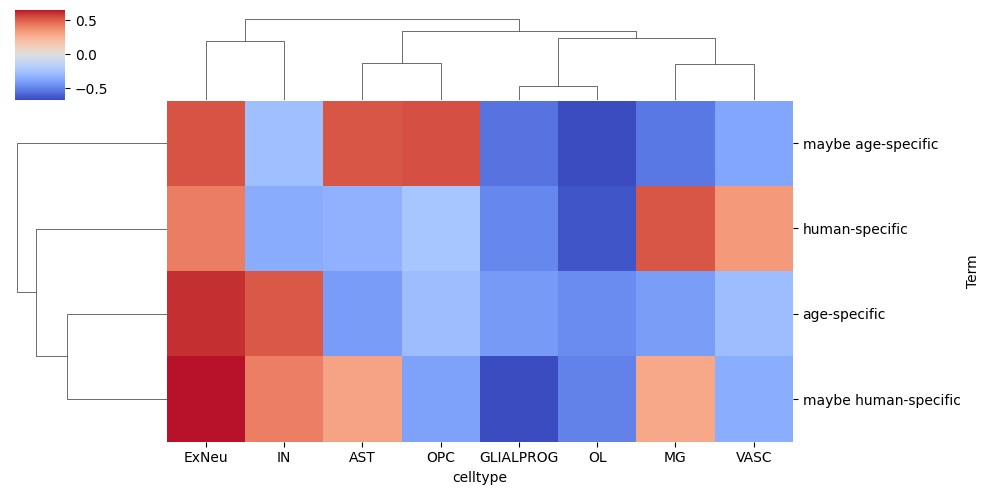

In [64]:
import seaborn as sns
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

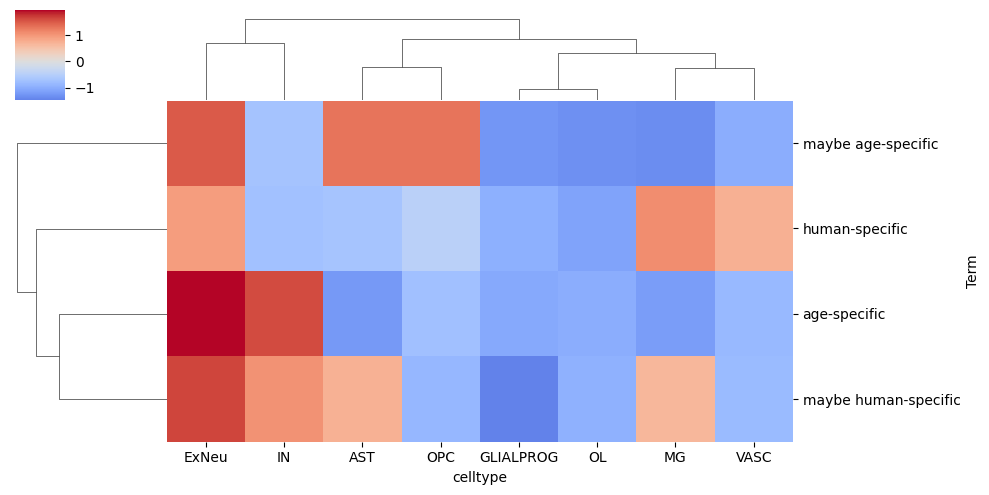

In [65]:
es_df = enrich_df.pivot(index='Term', columns='celltype', values='NES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

<Axes: xlabel='Term', ylabel='celltype'>

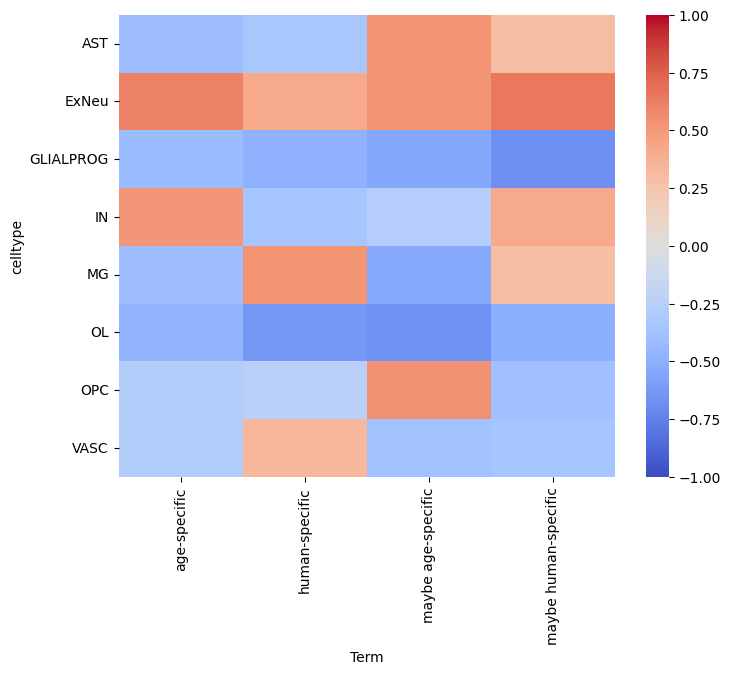

In [66]:
import seaborn as sns
fig = plt.figure(figsize=(8, 6))
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.heatmap(es_df.astype(float).T, cmap='coolwarm', center=0, vmin=-1, vmax=1)

### Wilcoxon

Specify DE test

In [67]:
key = 'wilcoxon'

Run enrichment for genesets

In [68]:
enrich_df = enrich_celltypes(celltypes, gene_sets, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='lfc_product', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/8 [00:00<?, ?it/s]

2024-07-04 17:18:08,339 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:18:08,954 [WARNING] Duplicated values found in preranked stats: 0.04% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:18:09,485 [WARNING] Duplicated values found in preranked stats: 0.04% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:18:10,531 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:18:11,095 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Name                Term        ES       NES NOM p-val FDR q-val  \
0  prerank  maybe age-specific  0.791714  1.389912  0.051622  0.141016   
1  prerank        age-specific -0.558332 -1.256633  0.142857  0.207048   

  FWER p-val Tag % Gene %                 Lead_genes celltype  
0      0.119  3/15  6.22%             ID2;LHX2;MACF1      AST  
1   0.319095  4/26  7.88%  ZBTB46;GNAI1;PDE1A;DLGAP4      AST

Process enrichment results

In [69]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                Term        ES       NES NOM p-val FDR q-val  \
0  prerank  maybe age-specific  0.791714  1.389912  0.051622  0.141016   
1  prerank        age-specific -0.558332 -1.256633  0.142857  0.207048   

  FWER p-val Tag % Gene %                 Lead_genes celltype  -log10(FDR)  \
0      0.119  3/15  6.22%             ID2;LHX2;MACF1      AST     0.847663   
1   0.319095  4/26  7.88%  ZBTB46;GNAI1;PDE1A;DLGAP4      AST     0.681835   

  direction  significant  
0  enriched  FDR >= 0.05  
1  depleted  FDR >= 0.05

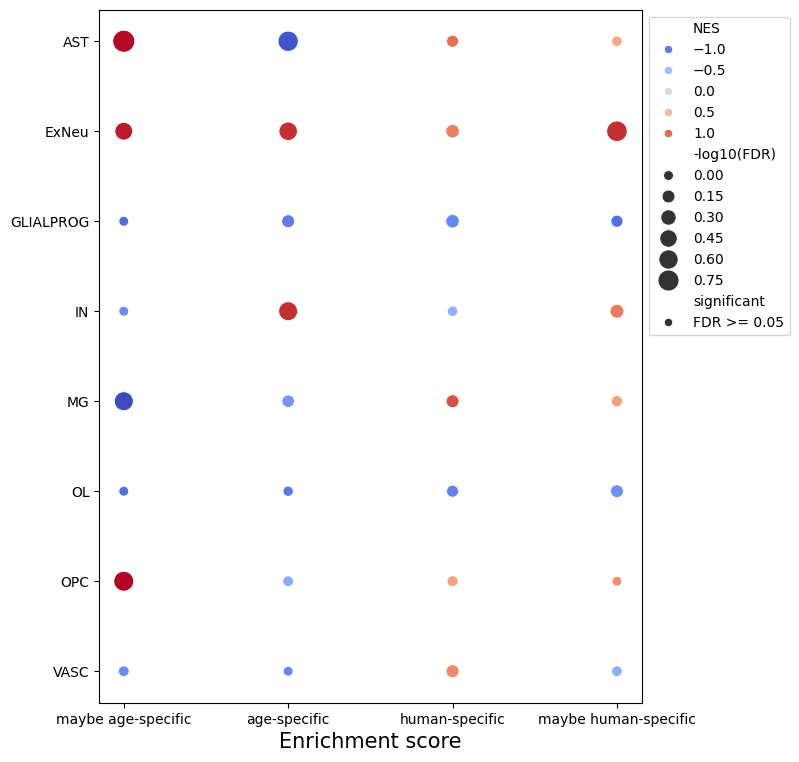

In [70]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='Term',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

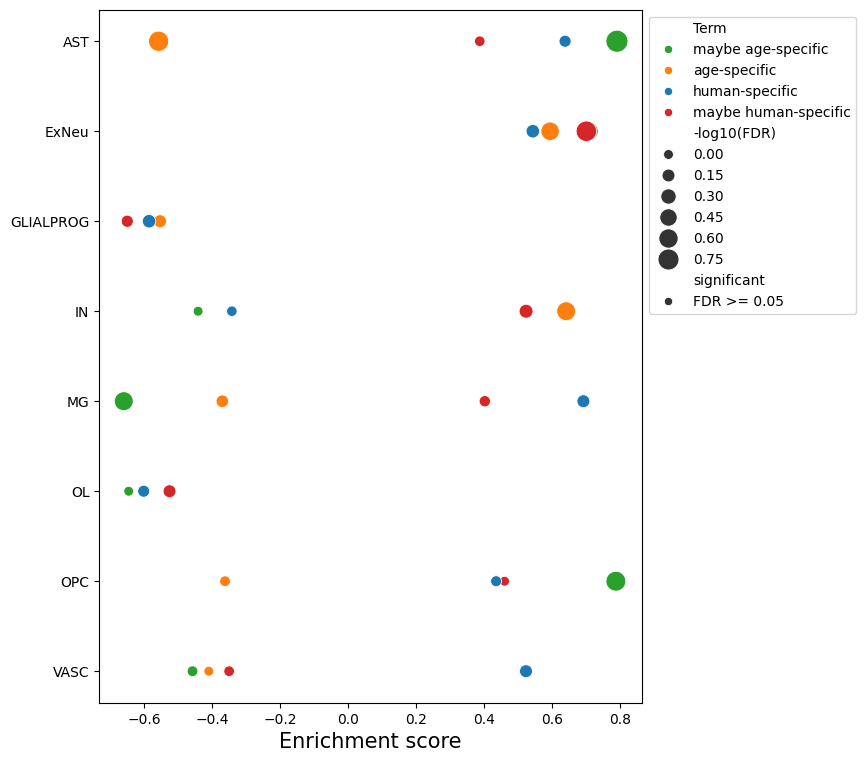

In [71]:
mpl.rcdefaults()
palette = {'human-specific': 'tab:blue', 'age-specific': 'tab:orange', 'maybe human-specific': 'tab:red', 'maybe age-specific': 'tab:green'}

enrichment_plot(
    enrich_res=enrich_df,
    x='ES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='Term',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

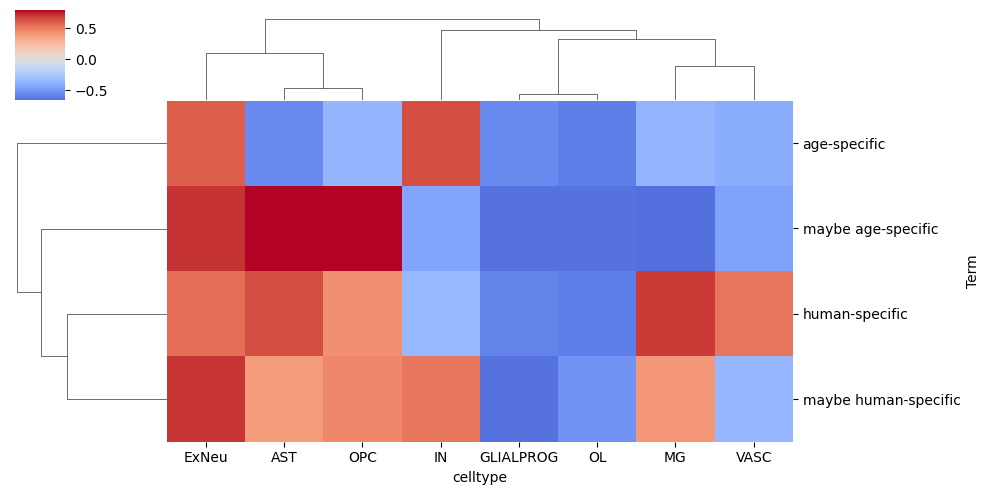

In [72]:
import seaborn as sns
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

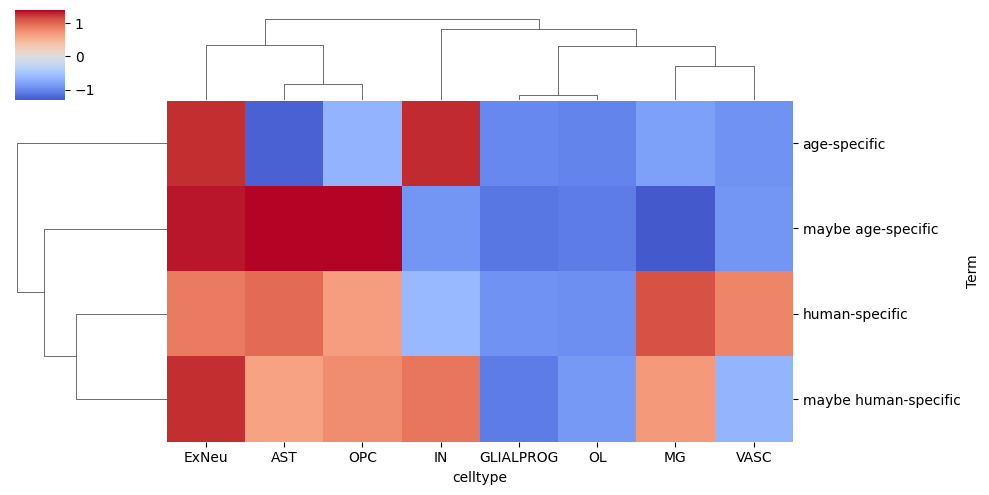

In [73]:
es_df = enrich_df.pivot(index='Term', columns='celltype', values='NES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

<Axes: xlabel='Term', ylabel='celltype'>

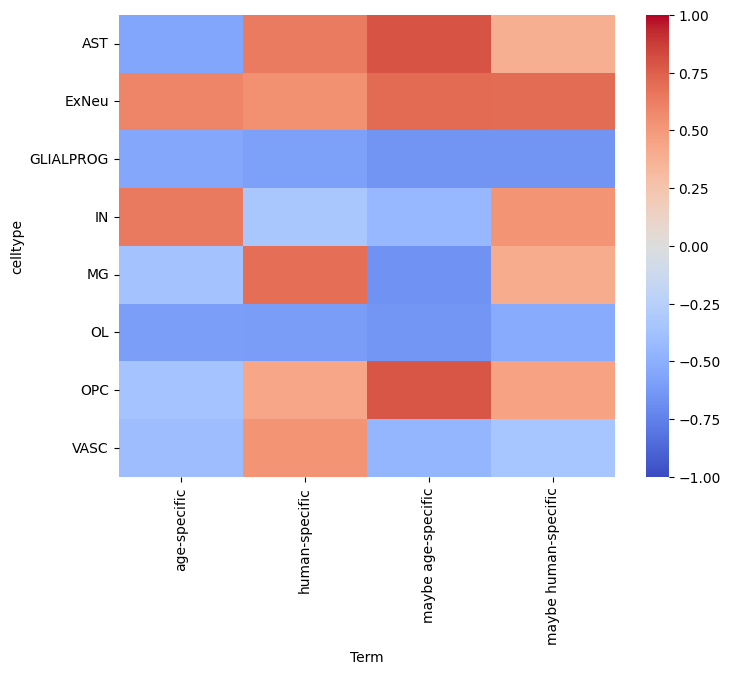

In [74]:
import seaborn as sns
fig = plt.figure(figsize=(8, 6))
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.heatmap(es_df.astype(float).T, cmap='coolwarm', center=0, vmin=-1, vmax=1)

### Logreg

Specify DE test

In [75]:
key = 'logreg'

Run enrichment for genesets

In [76]:
enrich_df = enrich_celltypes(celltypes, gene_sets, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='score', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/8 [00:00<?, ?it/s]

2024-07-04 17:18:13,216 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:18:13,707 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:18:14,274 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:18:14,930 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:18:16,124 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Name                Term        ES       NES NOM p-val FDR q-val  \
0  prerank        age-specific -0.477084 -1.384622  0.086957  0.231626   
1  prerank  maybe age-specific -0.397509 -1.007123  0.430407  0.438753   

  FWER p-val  Tag %  Gene %  \
0   0.208939  11/26  22.70%   
1   0.644693   6/15  12.24%   

                                          Lead_genes celltype  
0  PDE1A;ZBTB46;DLGAP4;GNAI1;ZBTB18;ETFB;NRXN1;PP...      AST  
1                 VAT1L;CD47;PTPRK;OLA1;SULF2;IGSF21      AST

Process enrichment results

In [77]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                Term        ES       NES NOM p-val FDR q-val  \
0  prerank        age-specific -0.477084 -1.384622  0.086957  0.231626   
1  prerank  maybe age-specific -0.397509 -1.007123  0.430407  0.438753   

  FWER p-val  Tag %  Gene %  \
0   0.208939  11/26  22.70%   
1   0.644693   6/15  12.24%   

                                          Lead_genes celltype  -log10(FDR)  \
0  PDE1A;ZBTB46;DLGAP4;GNAI1;ZBTB18;ETFB;NRXN1;PP...      AST     0.633342   
1                 VAT1L;CD47;PTPRK;OLA1;SULF2;IGSF21      AST     0.356791   

  direction  significant  
0  depleted  FDR >= 0.05  
1  depleted  FDR >= 0.05

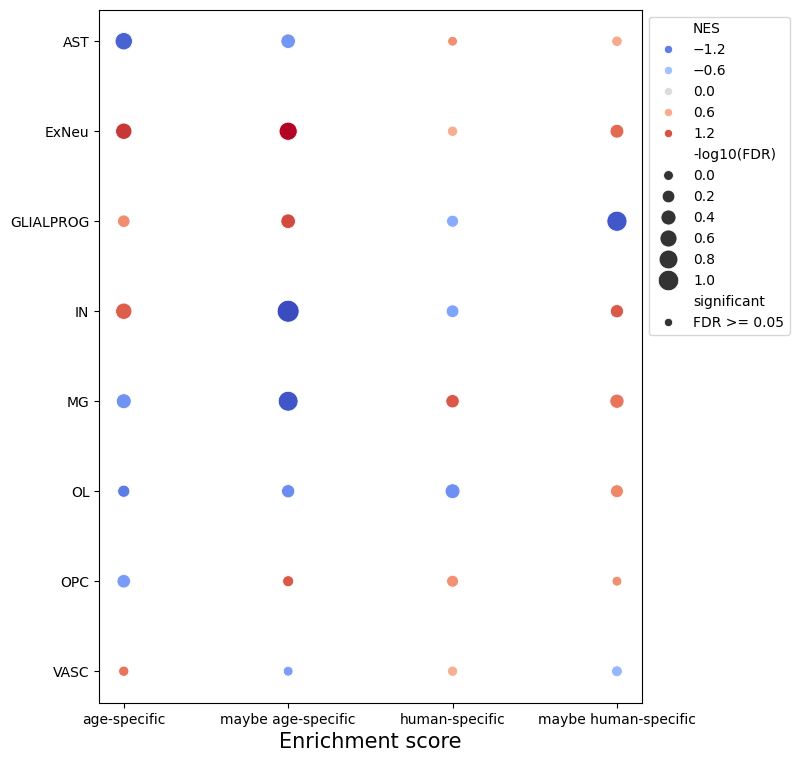

In [78]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='Term',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

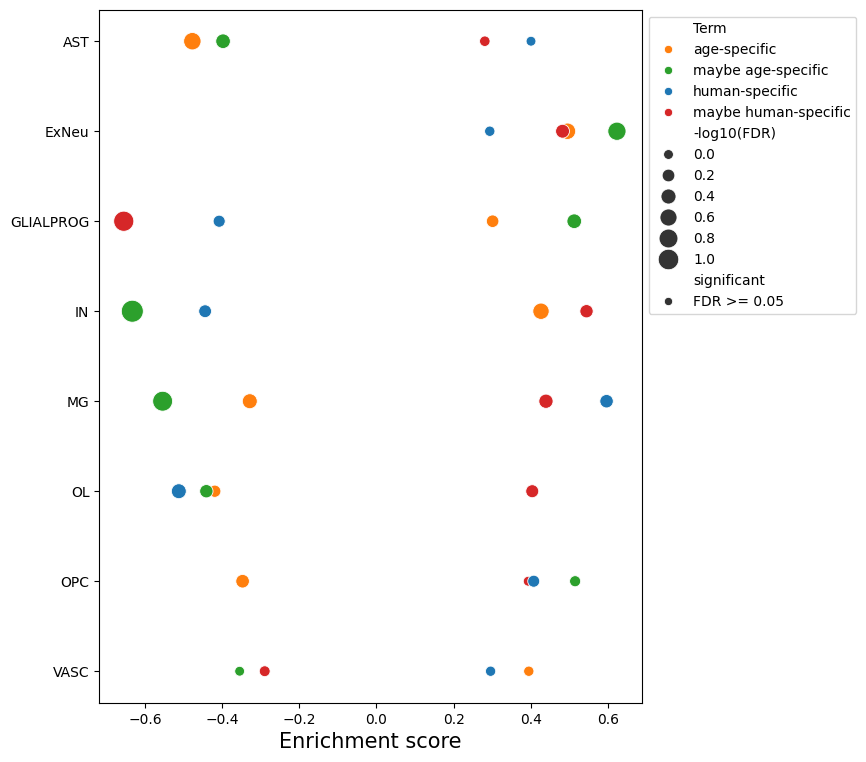

In [79]:
mpl.rcdefaults()
palette = {'human-specific': 'tab:blue', 'age-specific': 'tab:orange', 'maybe human-specific': 'tab:red', 'maybe age-specific': 'tab:green'}

enrichment_plot(
    enrich_res=enrich_df,
    x='ES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='Term',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

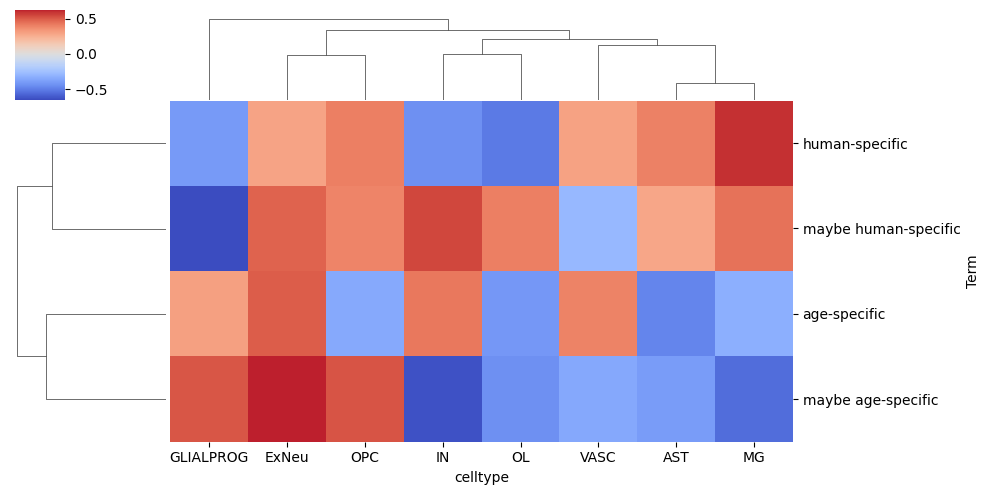

In [80]:
import seaborn as sns
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

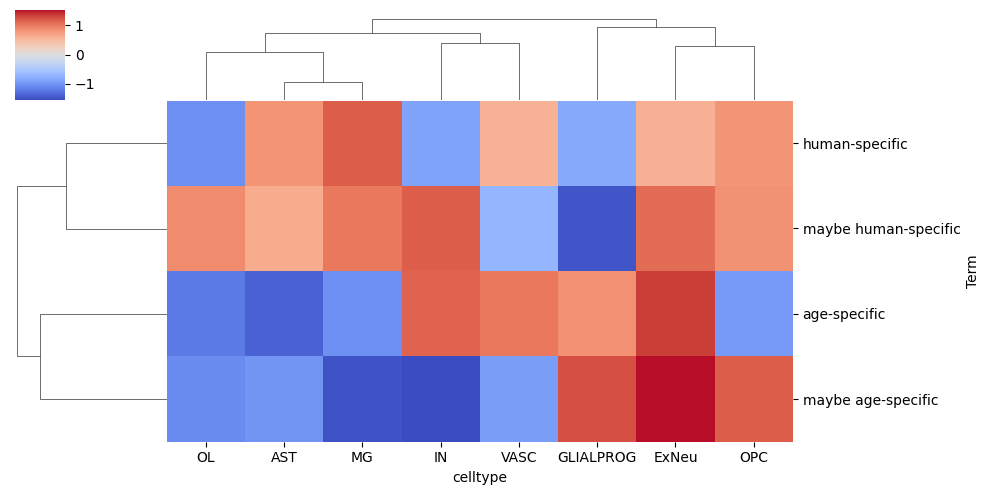

In [81]:
es_df = enrich_df.pivot(index='Term', columns='celltype', values='NES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

<Axes: xlabel='Term', ylabel='celltype'>

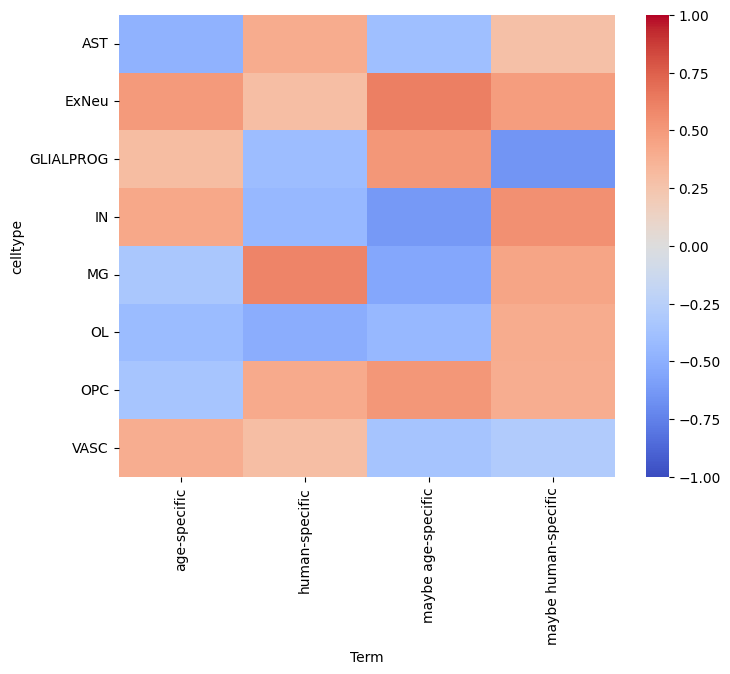

In [82]:
import seaborn as sns
fig = plt.figure(figsize=(8, 6))
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.heatmap(es_df.astype(float).T, cmap='coolwarm', center=0, vmin=-1, vmax=1)

### EdgeR

Run enrichment for genesets

In [83]:
enrich_df = enrich_celltypes(res_edgeR, gene_sets, gene_col='names', score_col='score', method='score', gsea_kw={'verbose': True})
enrich_df.head(2)

  0%|          | 0/8 [00:00<?, ?it/s]

2024-07-04 17:18:18,747 [WARNING] Duplicated values found in preranked stats: 0.25% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:18:18,748 [INFO] Parsing data files for GSEA.............................
2024-07-04 17:18:18,751 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
2024-07-04 17:18:18,752 [INFO] 0004 gene_sets used for further statistical testing.....
2024-07-04 17:18:18,754 [INFO] Start to run GSEA...Might take a while..................
2024-07-04 17:18:19,629 [INFO] Congratulations. GSEApy runs successfully................

2024-07-04 17:18:19,653 [WARNING] Duplicated values found in preranked stats: 0.27% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:18:19,653 [INFO] Parsing data files for GSEA.............................
2024-07-04 17:18:19,660 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
20

Name                Term       ES       NES NOM p-val FDR q-val  \
0  prerank  maybe age-specific  0.59835  1.238733  0.156216  0.577753   
1  prerank      human-specific  0.41119  0.758288  0.833922       1.0   

  FWER p-val Tag %  Gene %      Lead_genes celltype  
0      0.434  3/15   1.60%  ID2;MACF1;LHX2      AST  
1      0.998   2/8  16.33%     IGFBP2;AMZ2      AST

Process enrichment results

In [84]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                Term       ES       NES NOM p-val FDR q-val  \
0  prerank  maybe age-specific  0.59835  1.238733  0.156216  0.577753   
1  prerank      human-specific  0.41119  0.758288  0.833922       1.0   

  FWER p-val Tag %  Gene %      Lead_genes celltype  -log10(FDR) direction  \
0      0.434  3/15   1.60%  ID2;MACF1;LHX2      AST     0.237507  enriched   
1      0.998   2/8  16.33%     IGFBP2;AMZ2      AST    -0.000434  enriched   

   significant  
0  FDR >= 0.05  
1  FDR >= 0.05

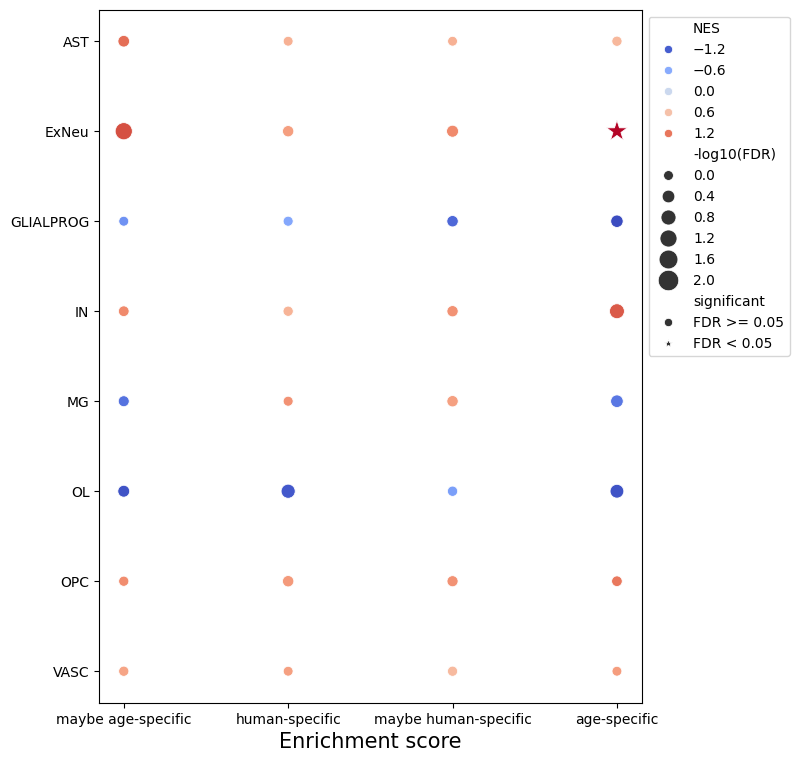

In [85]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='Term',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

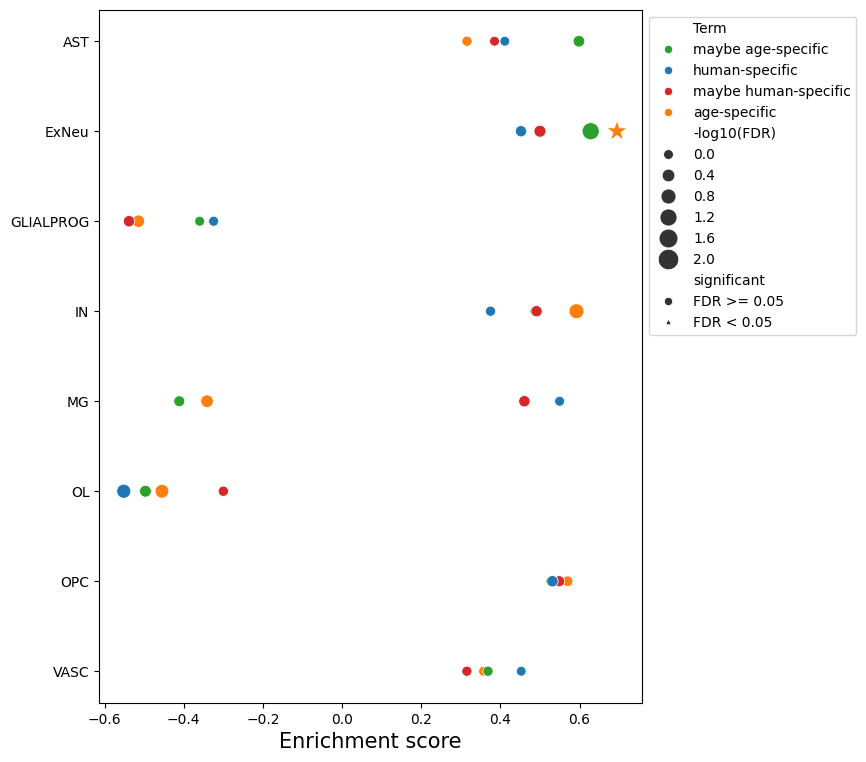

In [86]:
mpl.rcdefaults()
palette = {'human-specific': 'tab:blue', 'age-specific': 'tab:orange', 'maybe human-specific': 'tab:red', 'maybe age-specific': 'tab:green'}

enrichment_plot(
    enrich_res=enrich_df,
    x='ES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='Term',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

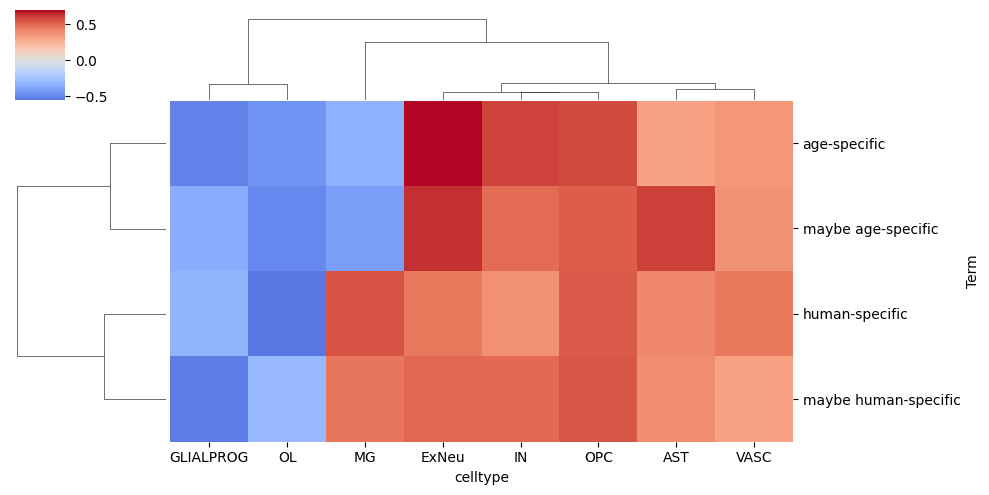

In [87]:
import seaborn as sns
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

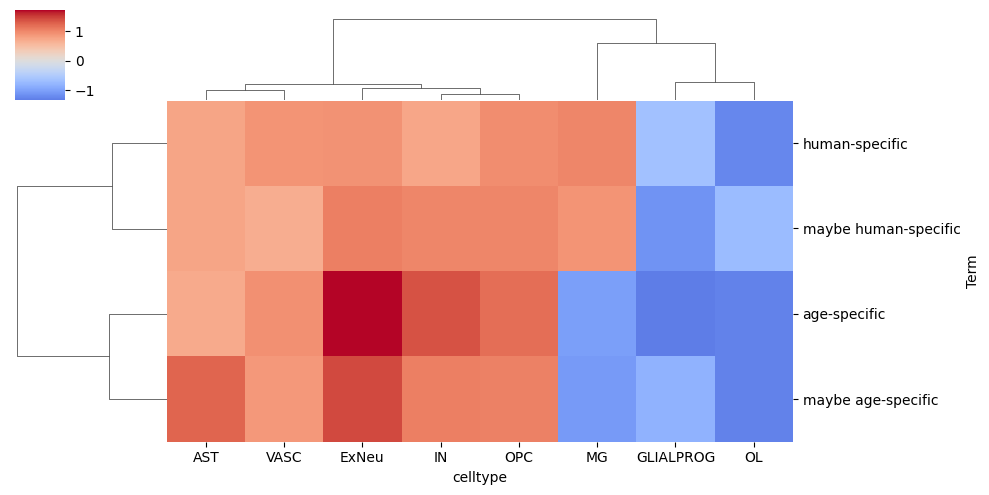

In [88]:
es_df = enrich_df.pivot(index='Term', columns='celltype', values='NES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

<Axes: xlabel='Term', ylabel='celltype'>

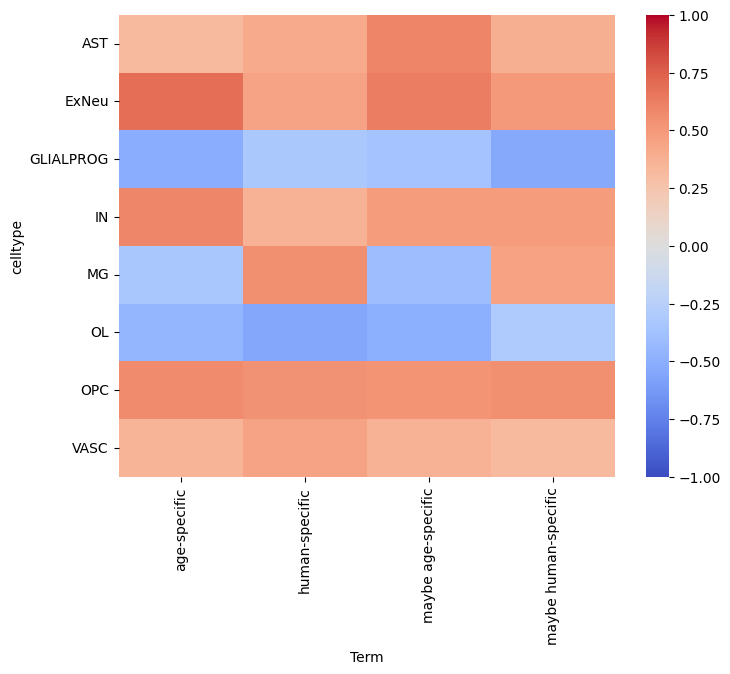

In [89]:
import seaborn as sns
fig = plt.figure(figsize=(8, 6))
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.heatmap(es_df.astype(float).T, cmap='coolwarm', center=0, vmin=-1, vmax=1)

### Gene visualization

Calculate average normalized expression

In [90]:
for lineage in gene_sets.keys():
    genes = scaled_adata.var_names.intersection(gene_sets[lineage])
    scaled_adata.obs[f'{lineage}_scaled'] = scaled_adata[:, genes].X.mean(axis=1)
scaled_adata.obs.head()

dataset    sample individual region  \
cell                                                                     
U01_AAACCTGAGGCGATAC-1_4350_BA9  Velmeshev  4350_BA9       4350    BA9   
U01_AAACCTGAGTACACCT-1_4350_BA9  Velmeshev  4350_BA9       4350    BA9   
U01_AAACCTGCAGCTGGCT-1_4350_BA9  Velmeshev  4350_BA9       4350    BA9   
U01_AAACCTGCAGTAGAGC-1_4350_BA9  Velmeshev  4350_BA9       4350    BA9   
U01_AAACCTGGTCTAAACC-1_4350_BA9  Velmeshev  4350_BA9       4350    BA9   

                                      age age(days)  age_range sex_original  \
cell                                                                          
U01_AAACCTGAGGCGATAC-1_4350_BA9  196 days     462.0  0-1 years         Male   
U01_AAACCTGAGTACACCT-1_4350_BA9  196 days     462.0  0-1 years         Male   
U01_AAACCTGCAGCTGGCT-1_4350_BA9  196 days     462.0  0-1 years         Male   
U01_AAACCTGCAGTAGAGC-1_4350_BA9  196 days     462.0  0-1 years         Male   
U01_AAACCTGGTCTAAACC-1_4350_BA9  196 days     462.0  0-1 years         Male   

                                region_broad chemistry PMI   sex  \
cell                                                               
U01_AAACCTGAGGCGATAC-1_4350_BA9           FC        V2  20  Male   
U01_AAACCTGAGTACACCT-1_4350_BA9           FC        V2  20  Male   
U01_AAACCTGCAGCTGGCT-1_4350_BA9           FC        V2  20  Male   
U01_AAACCTGCAGTAGAGC-1_4350_BA9           FC        V2  20  Male   
U01_AAACCTGGTCTAAACC-1_4350_BA9           FC        V2  20  Male   

                                seurat_clusters lineage  \
cell                                                      
U01_AAACCTGAGGCGATAC-1_4350_BA9              20   ExNeu   
U01_AAACCTGAGTACACCT-1_4350_BA9              17   ExNeu   
U01_AAACCTGCAGCTGGCT-1_4350_BA9              10      IN   
U01_AAACCTGCAGTAGAGC-1_4350_BA9              21   ExNeu   
U01_AAACCTGGTCTAAACC-1_4350_BA9              10      IN   

                                 human_specific_scaled  age-specific_scaled  \
cell                                                                          
U01_AAACCTGAGGCGATAC-1_4350_BA9               0.242244             0.169778   
U01_AAACCTGAGTACACCT-1_4350_BA9              -0.072817            -0.289827   
U01_AAACCTGCAGCTGGCT-1_4350_BA9              -0.034043             0.172426   
U01_AAACCTGCAGTAGAGC-1_4350_BA9               0.531282             0.781447   
U01_AAACCTGGTCTAAACC-1_4350_BA9               0.006879             0.215700   

                                 maybe age-specific_scaled  \
cell                                                         
U01_AAACCTGAGGCGATAC-1_4350_BA9                   0.525614   
U01_AAACCTGAGTACACCT-1_4350_BA9                   0.303298   
U01_AAACCTGCAGCTGGCT-1_4350_BA9                  -0.144213   
U01_AAACCTGCAGTAGAGC-1_4350_BA9                   0.509838   
U01_AAACCTGGTCTAAACC-1_4350_BA9                   0.214446   

                                 maybe human-specific_scaled  \
cell                                                           
U01_AAACCTGAGGCGATAC-1_4350_BA9                     0.320317   
U01_AAACCTGAGTACACCT-1_4350_BA9                    -0.326632   
U01_AAACCTGCAGCTGGCT-1_4350_BA9                    -0.319896   
U01_AAACCTGCAGTAGAGC-1_4350_BA9                     0.324053   
U01_AAACCTGGTCTAAACC-1_4350_BA9                    -0.491317   

                                 human-specific_scaled  
cell                                                    
U01_AAACCTGAGGCGATAC-1_4350_BA9              -0.147600  
U01_AAACCTGAGTACACCT-1_4350_BA9               0.195669  
U01_AAACCTGCAGCTGGCT-1_4350_BA9              -0.085273  
U01_AAACCTGCAGTAGAGC-1_4350_BA9               0.099986  
U01_AAACCTGGTCTAAACC-1_4350_BA9              -0.356485

Vusualize

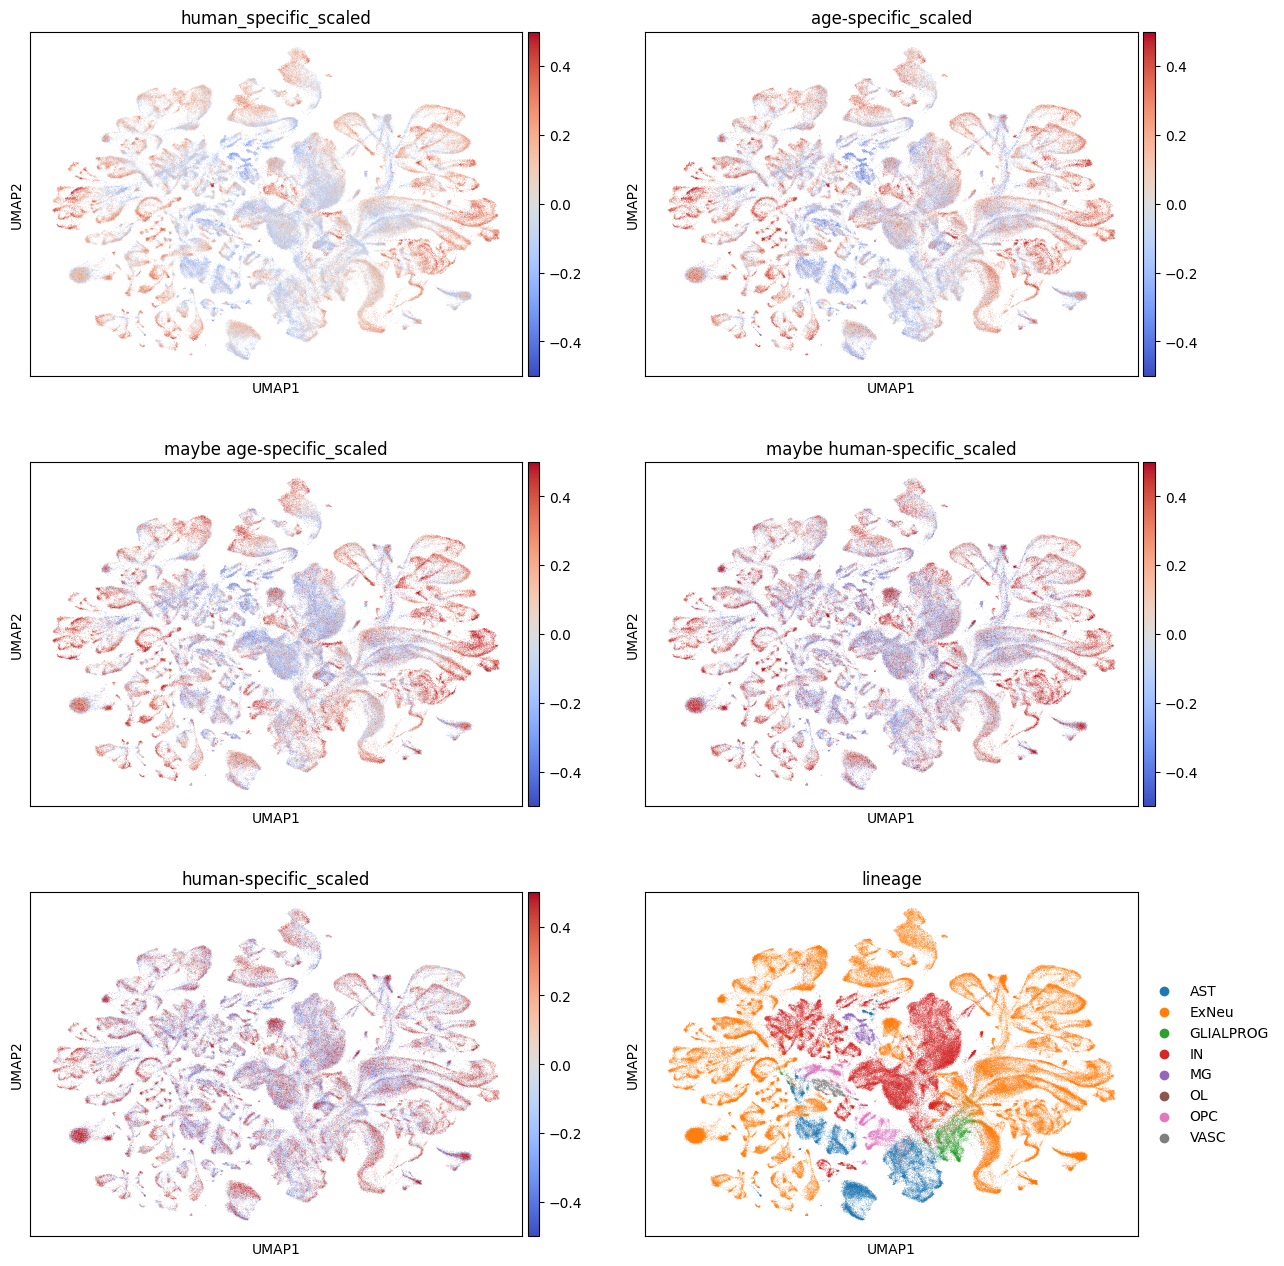

In [91]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmax=0.5, vmin=-0.5)
color = [
    'human_specific_scaled', 
    'age-specific_scaled', 
    'maybe age-specific_scaled', 
    'maybe human-specific_scaled', 
    'human-specific_scaled', 
    'lineage'
    ]

sc.pl.umap(scaled_adata, color=color, cmap=cmap, norm=norm, ncols=2)

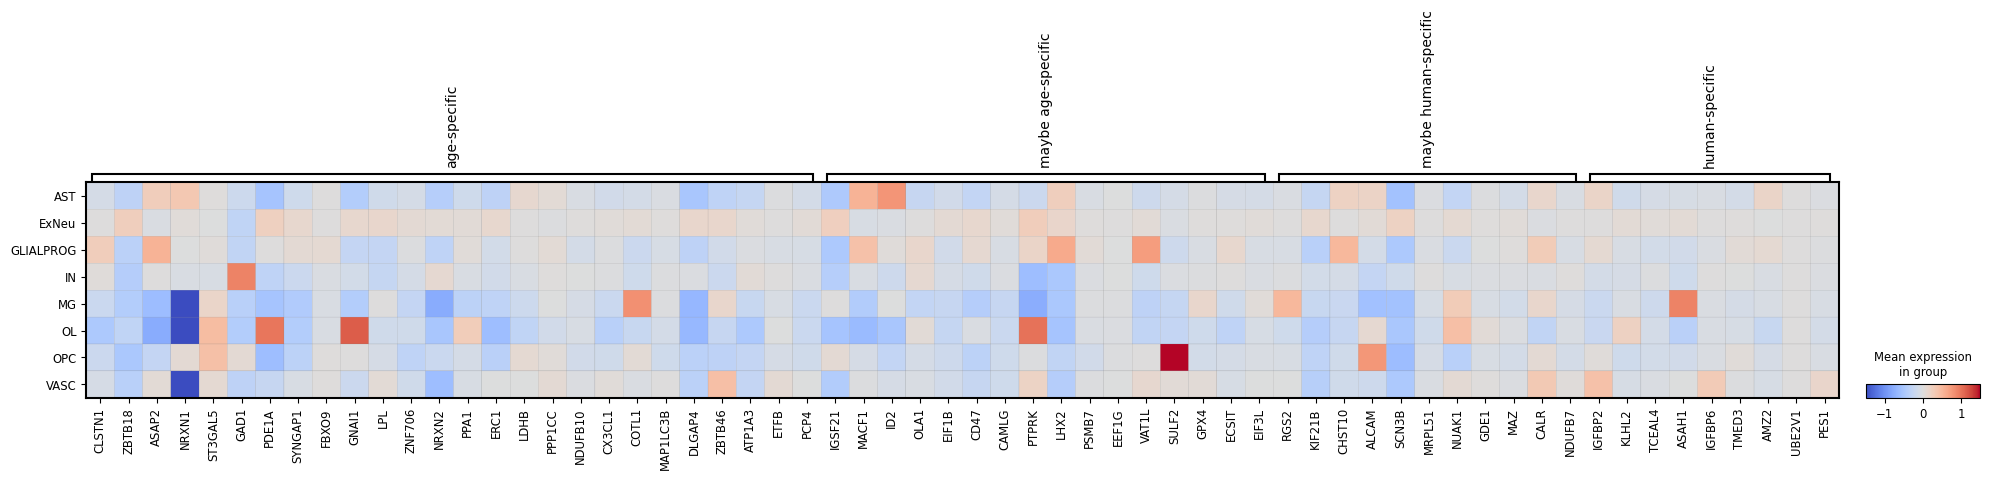

In [92]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmax=1.5, vmin=-1.5)
gene_sets_inter = {key: scaled_adata.var_names.intersection(value) for key, value in gene_sets.items()}

sc.pl.matrixplot(scaled_adata, gene_sets_inter, groupby='lineage', cmap='coolwarm', norm=norm)

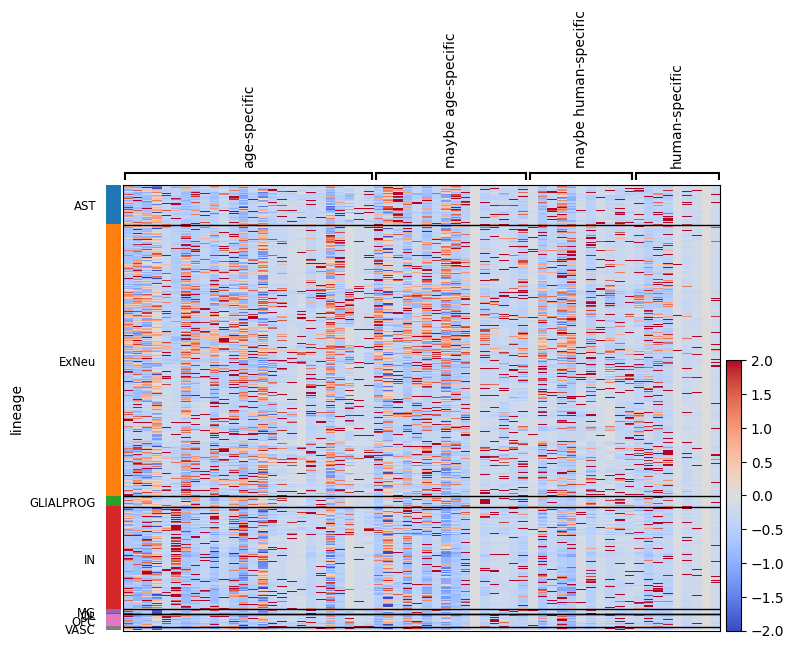

In [93]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmax=2, vmin=-2)
gene_sets_inter = {key: scaled_adata.var_names.intersection(value) for key, value in gene_sets.items()}

sc.pl.heatmap(scaled_adata, gene_sets_inter, groupby='lineage', cmap='coolwarm', norm=norm)

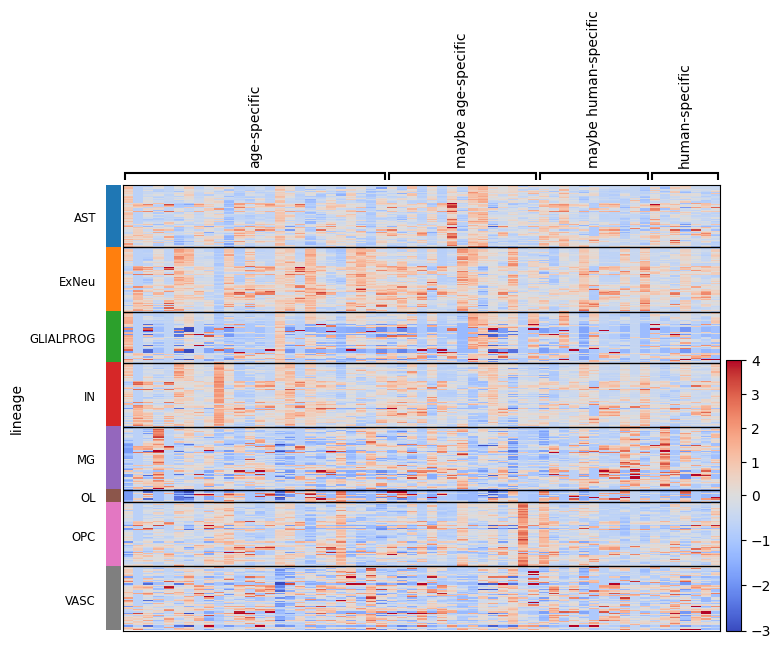

In [94]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0)
gene_sets_inter = {key: scaled_adata_pb.var_names.intersection(value) for key, value in gene_sets.items()}

sc.pl.heatmap(scaled_adata_pb, gene_sets_inter, groupby='lineage', cmap='coolwarm', vcenter=0, vmin=-3, vmax=4)

## Enrich for clusters

In [95]:
gene_sets = dict()
for label in cluster_groups.label.unique():
  gene_sets[f'lineage{label}'] = cluster_groups[cluster_groups.label == label].index.to_list()

### T-test

Specify DE test

In [96]:
key = 't-test'

Run enrichment for genesets

In [97]:
enrich_df = enrich_celltypes(celltypes, gene_sets, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='score', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/8 [00:00<?, ?it/s]

2024-07-04 17:18:34,385 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:18:34,950 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:18:36,113 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:18:36,717 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:18:37,818 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:18:38,477 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be

Name      Term        ES       NES NOM p-val FDR q-val FWER p-val Tag %  \
0  prerank  lineage2 -0.722637 -1.498135  0.055556  0.169133   0.154004   5/7   
1  prerank  lineage1  0.565997  1.391154  0.083488  0.298861      0.274  2/13   

   Gene %                   Lead_genes celltype  
0  21.40%  GNAI1;NUAK1;OLA1;KLHL2;PPA1      AST  
1  11.02%                   ASAP2;AMZ2      AST

Process enrichment results

In [98]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name      Term        ES       NES NOM p-val FDR q-val FWER p-val Tag %  \
0  prerank  lineage2 -0.722637 -1.498135  0.055556  0.169133   0.154004   5/7   
1  prerank  lineage1  0.565997  1.391154  0.083488  0.298861      0.274  2/13   

   Gene %                   Lead_genes celltype  -log10(FDR) direction  \
0  21.40%  GNAI1;NUAK1;OLA1;KLHL2;PPA1      AST     0.769211  depleted   
1  11.02%                   ASAP2;AMZ2      AST     0.523079  enriched   

   significant  
0  FDR >= 0.05  
1  FDR >= 0.05

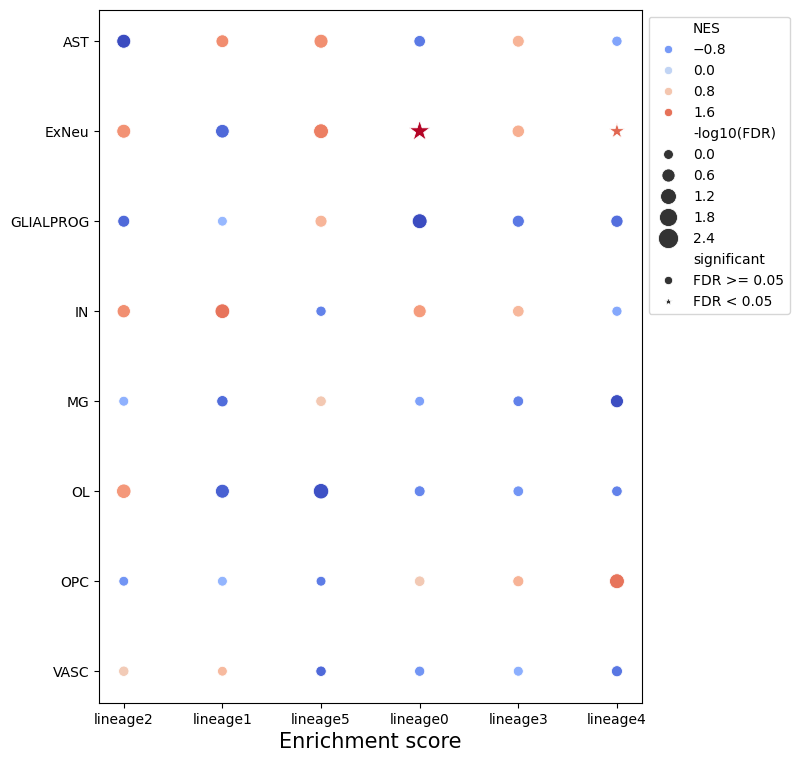

In [99]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='Term',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

C:\Users\claptar\AppData\Local\Temp\ipykernel_36280\2110194606.py:6: UserWarning: The palette list has more values (12) than needed (6), which may not be intended.
  ax = sns.scatterplot(data=enrich_res.reset_index(), **kw_scatterplot)


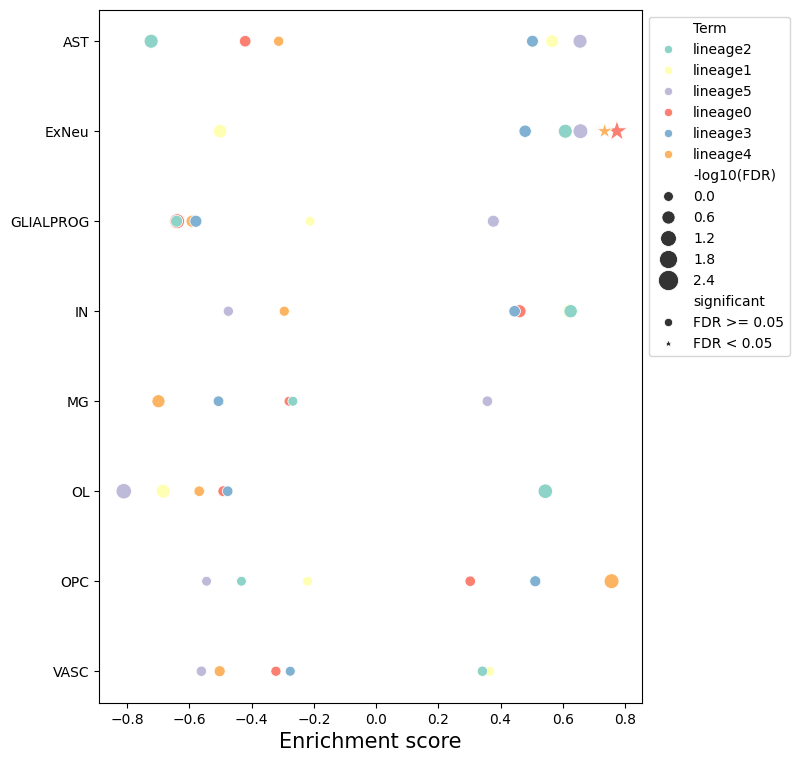

In [100]:
mpl.rcdefaults()
palette = sns.color_palette("Set3")

enrichment_plot(
    enrich_res=enrich_df,
    x='ES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='Term',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

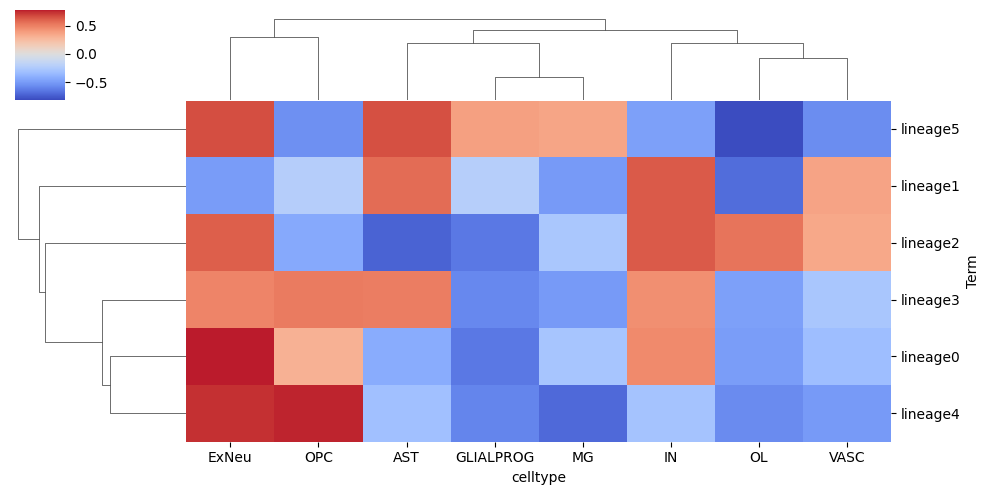

In [101]:
import seaborn as sns
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

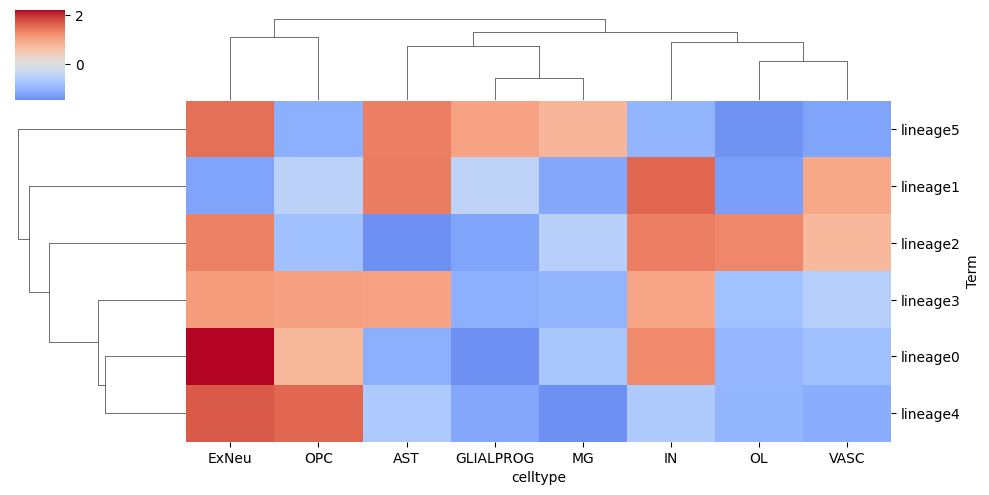

In [102]:
es_df = enrich_df.pivot(index='Term', columns='celltype', values='NES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

<Axes: xlabel='Term', ylabel='celltype'>

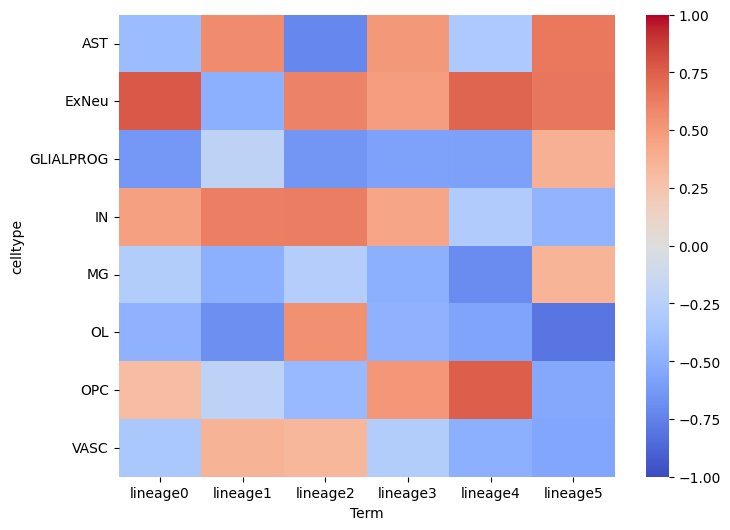

In [103]:
import seaborn as sns
fig = plt.figure(figsize=(8, 6))
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.heatmap(es_df.astype(float).T, cmap='coolwarm', center=0, vmin=-1, vmax=1)

### Wilcoxon

Specify DE test

In [104]:
key = 'wilcoxon'

Run enrichment for genesets

In [105]:
enrich_df = enrich_celltypes(celltypes, gene_sets, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='lfc_product', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/8 [00:00<?, ?it/s]

2024-07-04 17:18:40,566 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:18:41,182 [WARNING] Duplicated values found in preranked stats: 0.04% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:18:41,756 [WARNING] Duplicated values found in preranked stats: 0.04% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:18:43,068 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:18:43,813 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Name      Term        ES       NES NOM p-val FDR q-val FWER p-val Tag %  \
0  prerank  lineage1  0.831424   1.41998    0.0375  0.114827      0.106  2/13   
1  prerank  lineage5   0.86457  1.368544  0.059105  0.125889      0.217   2/8   

  Gene %   Lead_genes celltype  
0  9.40%   AMZ2;ASAP2      AST  
1  4.74%  LHX2;CHST10      AST

Process enrichment results

In [106]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name      Term        ES       NES NOM p-val FDR q-val FWER p-val Tag %  \
0  prerank  lineage1  0.831424   1.41998    0.0375  0.114827      0.106  2/13   
1  prerank  lineage5   0.86457  1.368544  0.059105  0.125889      0.217   2/8   

  Gene %   Lead_genes celltype  -log10(FDR) direction  significant  
0  9.40%   AMZ2;ASAP2      AST     0.936188  enriched  FDR >= 0.05  
1  4.74%  LHX2;CHST10      AST     0.896577  enriched  FDR >= 0.05

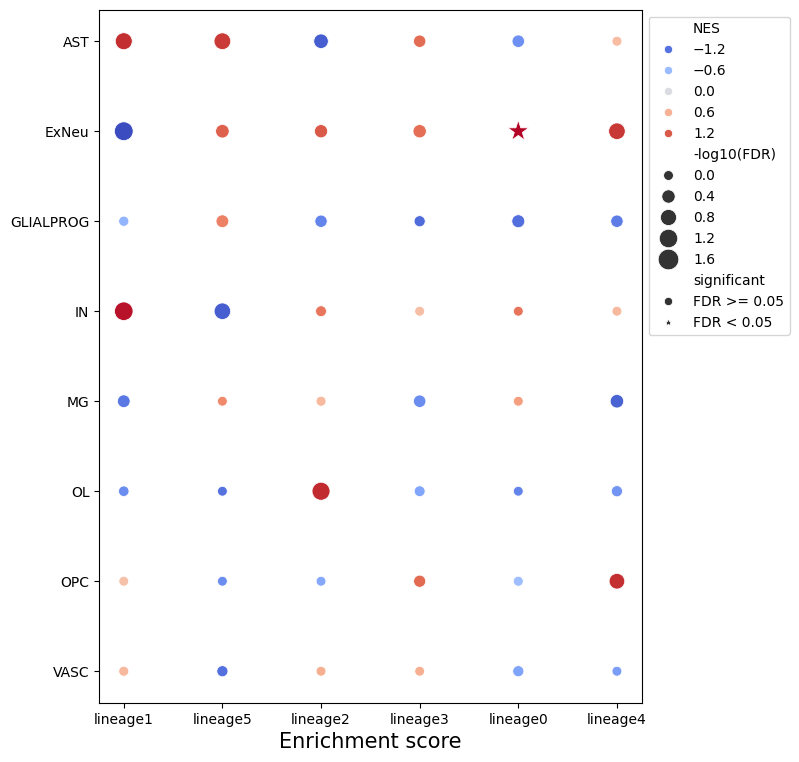

In [107]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='Term',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

C:\Users\claptar\AppData\Local\Temp\ipykernel_36280\2110194606.py:6: UserWarning: The palette list has more values (12) than needed (6), which may not be intended.
  ax = sns.scatterplot(data=enrich_res.reset_index(), **kw_scatterplot)


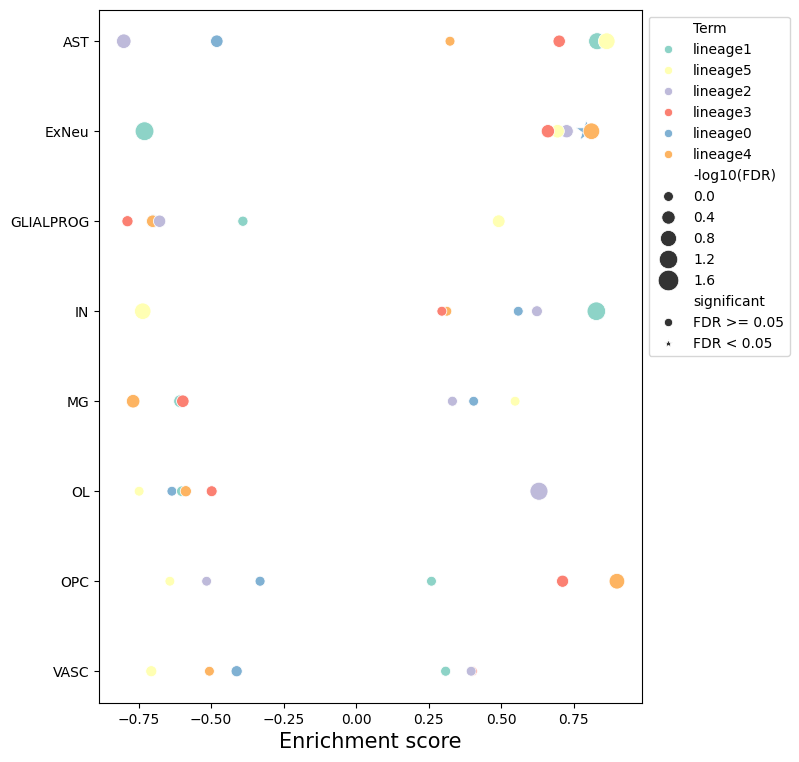

In [108]:
mpl.rcdefaults()
palette = sns.color_palette("Set3")

enrichment_plot(
    enrich_res=enrich_df,
    x='ES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='Term',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

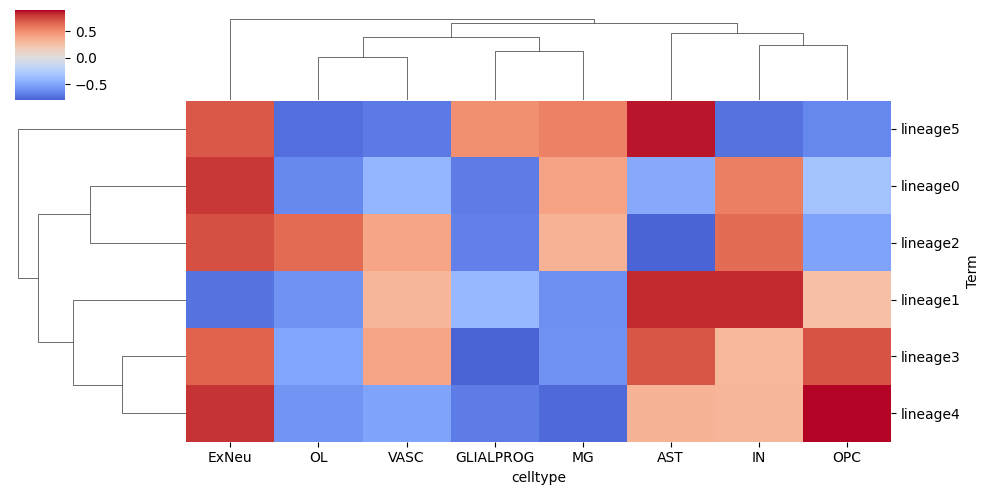

In [109]:
import seaborn as sns
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

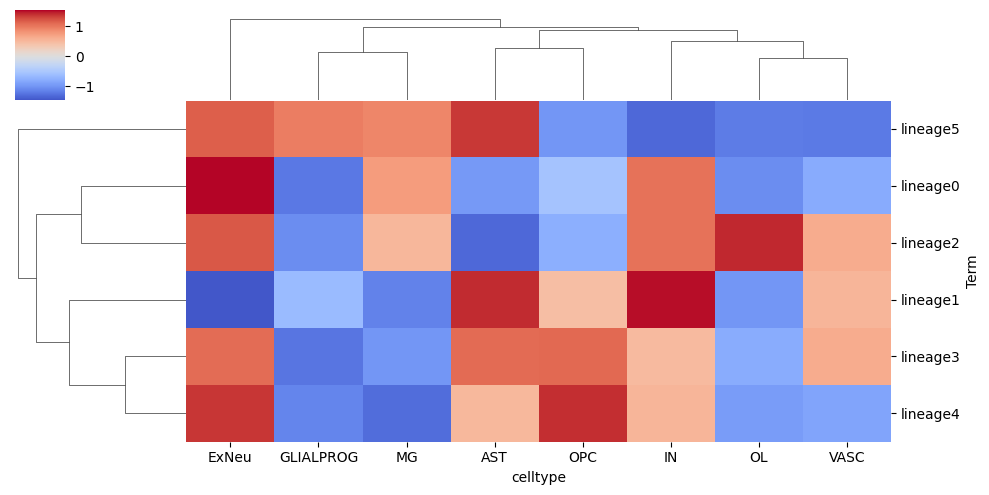

In [110]:
es_df = enrich_df.pivot(index='Term', columns='celltype', values='NES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

<Axes: xlabel='Term', ylabel='celltype'>

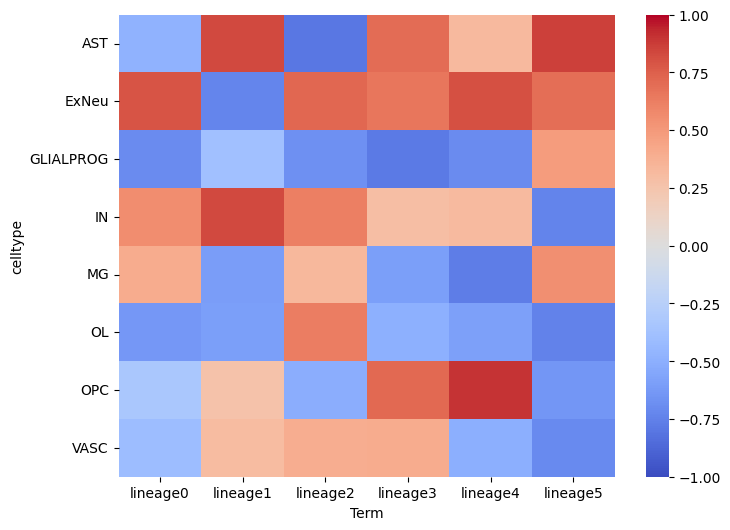

In [111]:
import seaborn as sns
fig = plt.figure(figsize=(8, 6))
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.heatmap(es_df.astype(float).T, cmap='coolwarm', center=0, vmin=-1, vmax=1)

### Logreg

Specify DE test

In [112]:
key = 'logreg'

Run enrichment for genesets

In [113]:
enrich_df = enrich_celltypes(celltypes, gene_sets, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='score', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/8 [00:00<?, ?it/s]

2024-07-04 17:18:46,177 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:18:46,757 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:18:47,415 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:18:48,331 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:18:49,540 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Name      Term        ES       NES NOM p-val FDR q-val FWER p-val Tag %  \
0  prerank  lineage2 -0.825772 -1.717919  0.002075  0.019334   0.018424   4/7   
1  prerank  lineage4 -0.602584 -1.277652  0.202151   0.29377   0.439099   4/8   

   Gene %               Lead_genes celltype  
0  10.84%   KLHL2;OLA1;NUAK1;GNAI1      AST  
1  12.24%  VAT1L;CD47;PTPRK;IGSF21      AST

Process enrichment results

In [114]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name      Term        ES       NES NOM p-val FDR q-val FWER p-val Tag %  \
0  prerank  lineage2 -0.825772 -1.717919  0.002075  0.019334   0.018424   4/7   
1  prerank  lineage4 -0.602584 -1.277652  0.202151   0.29377   0.439099   4/8   

   Gene %               Lead_genes celltype  -log10(FDR) direction  \
0  10.84%   KLHL2;OLA1;NUAK1;GNAI1      AST     1.691776  depleted   
1  12.24%  VAT1L;CD47;PTPRK;IGSF21      AST     0.530517  depleted   

   significant  
0   FDR < 0.05  
1  FDR >= 0.05

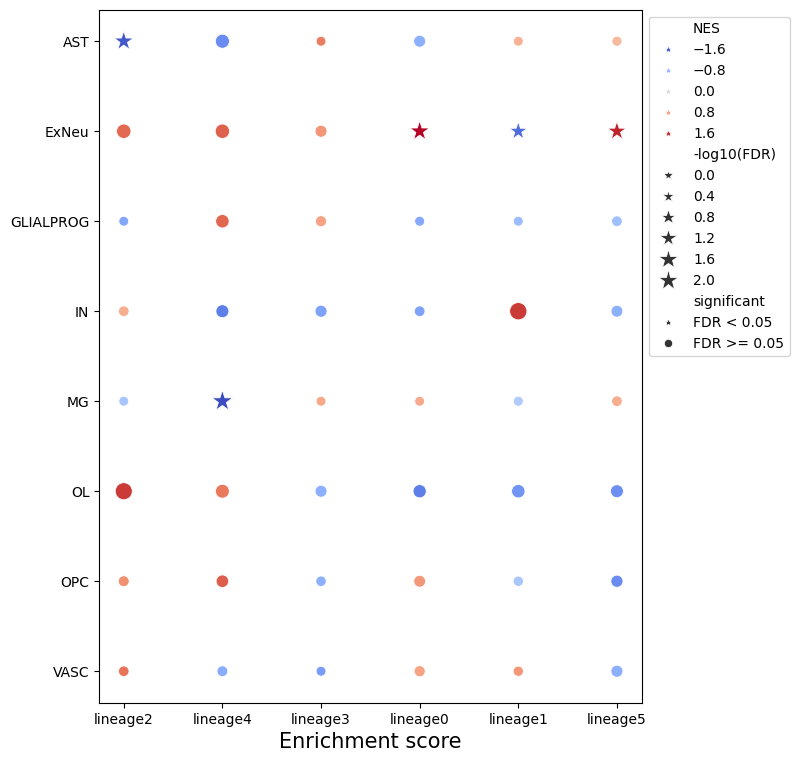

In [115]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='Term',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

C:\Users\claptar\AppData\Local\Temp\ipykernel_36280\2110194606.py:6: UserWarning: The palette list has more values (12) than needed (6), which may not be intended.
  ax = sns.scatterplot(data=enrich_res.reset_index(), **kw_scatterplot)


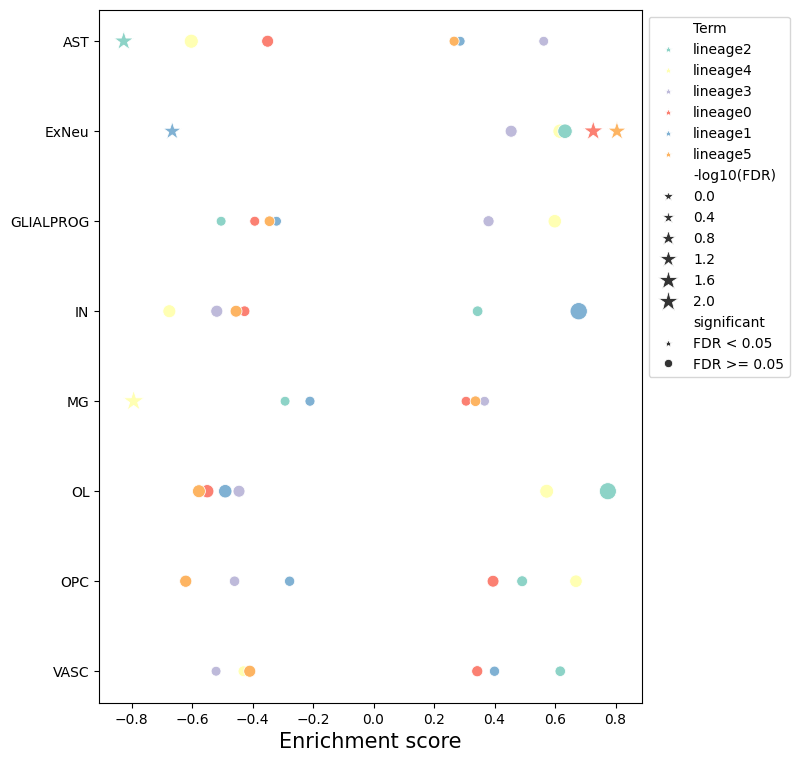

In [116]:
mpl.rcdefaults()
palette = sns.color_palette("Set3")

enrichment_plot(
    enrich_res=enrich_df,
    x='ES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='Term',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

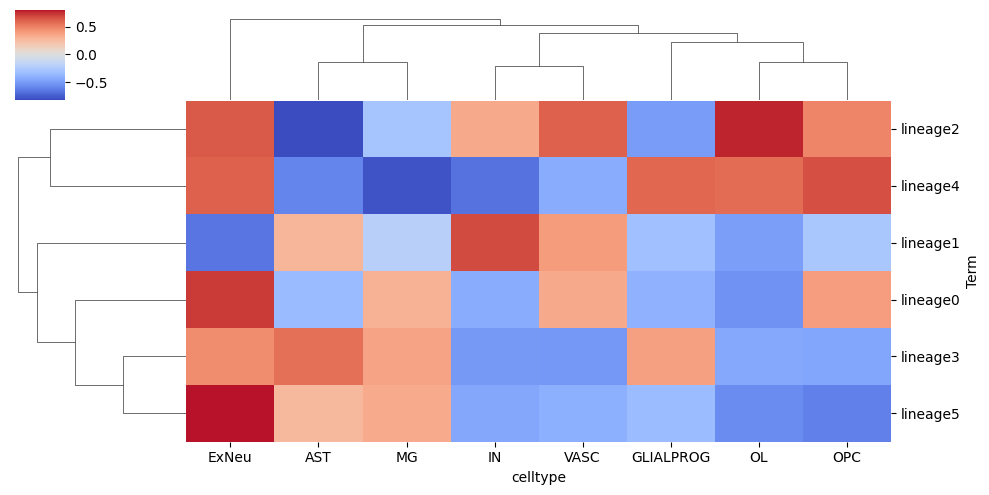

In [117]:
import seaborn as sns
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

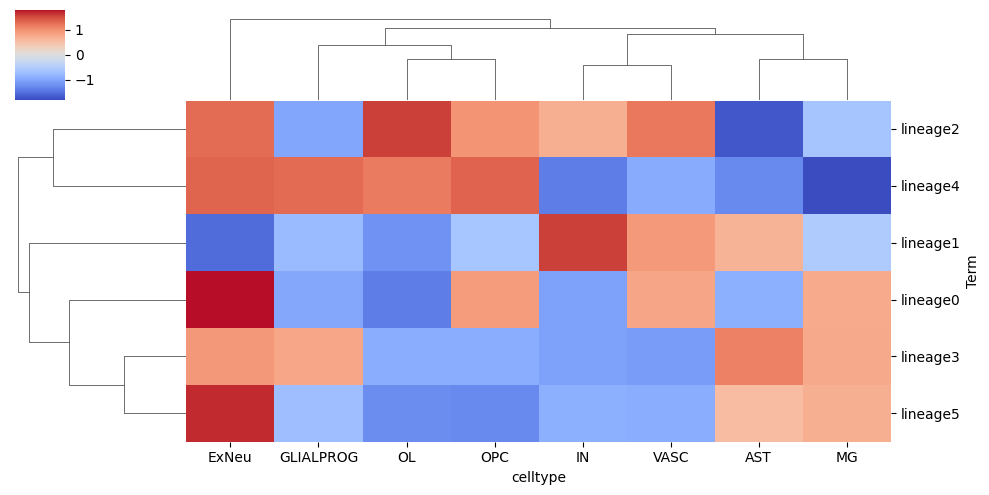

In [118]:
es_df = enrich_df.pivot(index='Term', columns='celltype', values='NES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

<Axes: xlabel='Term', ylabel='celltype'>

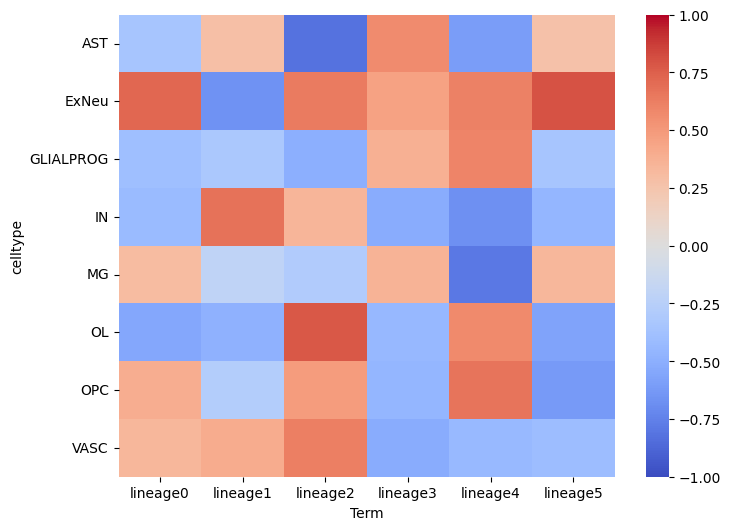

In [119]:
import seaborn as sns
fig = plt.figure(figsize=(8, 6))
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.heatmap(es_df.astype(float).T, cmap='coolwarm', center=0, vmin=-1, vmax=1)

### EdgeR

Run enrichment for genesets

In [120]:
enrich_df = enrich_celltypes(res_edgeR, gene_sets, gene_col='names', score_col='score', method='score', gsea_kw={'verbose': True})
enrich_df.head(2)

  0%|          | 0/8 [00:00<?, ?it/s]

2024-07-04 17:18:52,182 [WARNING] Duplicated values found in preranked stats: 0.25% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:18:52,191 [INFO] Parsing data files for GSEA.............................
2024-07-04 17:18:52,194 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
2024-07-04 17:18:52,195 [INFO] 0006 gene_sets used for further statistical testing.....
2024-07-04 17:18:52,195 [INFO] Start to run GSEA...Might take a while..................
2024-07-04 17:18:53,065 [INFO] Congratulations. GSEApy runs successfully................

2024-07-04 17:18:53,065 [WARNING] Duplicated values found in preranked stats: 0.27% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:18:53,081 [INFO] Parsing data files for GSEA.............................
2024-07-04 17:18:53,081 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
20

Name      Term        ES       NES NOM p-val FDR q-val FWER p-val Tag %  \
0  prerank  lineage2 -0.798193 -1.778228  0.012821  0.019704   0.027211   4/7   
1  prerank  lineage5  0.703406  1.313853  0.092593  0.417309       0.37   2/9   

  Gene %              Lead_genes celltype  
0  7.30%  GNAI1;NUAK1;OLA1;KLHL2      AST  
1  5.88%             LHX2;CHST10      AST

Process enrichment results

In [121]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name      Term        ES       NES NOM p-val FDR q-val FWER p-val Tag %  \
0  prerank  lineage2 -0.798193 -1.778228  0.012821  0.019704   0.027211   4/7   
1  prerank  lineage5  0.703406  1.313853  0.092593  0.417309       0.37   2/9   

  Gene %              Lead_genes celltype  -log10(FDR) direction  significant  
0  7.30%  GNAI1;NUAK1;OLA1;KLHL2      AST     1.683937  depleted   FDR < 0.05  
1  5.88%             LHX2;CHST10      AST     0.378503  enriched  FDR >= 0.05

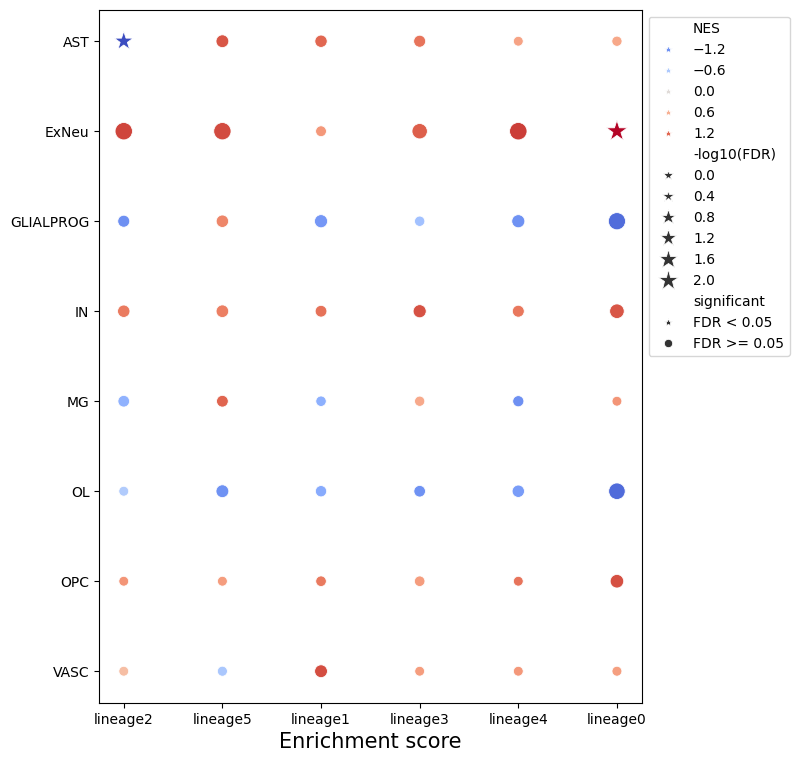

In [122]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='Term',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

C:\Users\claptar\AppData\Local\Temp\ipykernel_36280\2110194606.py:6: UserWarning: The palette list has more values (12) than needed (6), which may not be intended.
  ax = sns.scatterplot(data=enrich_res.reset_index(), **kw_scatterplot)


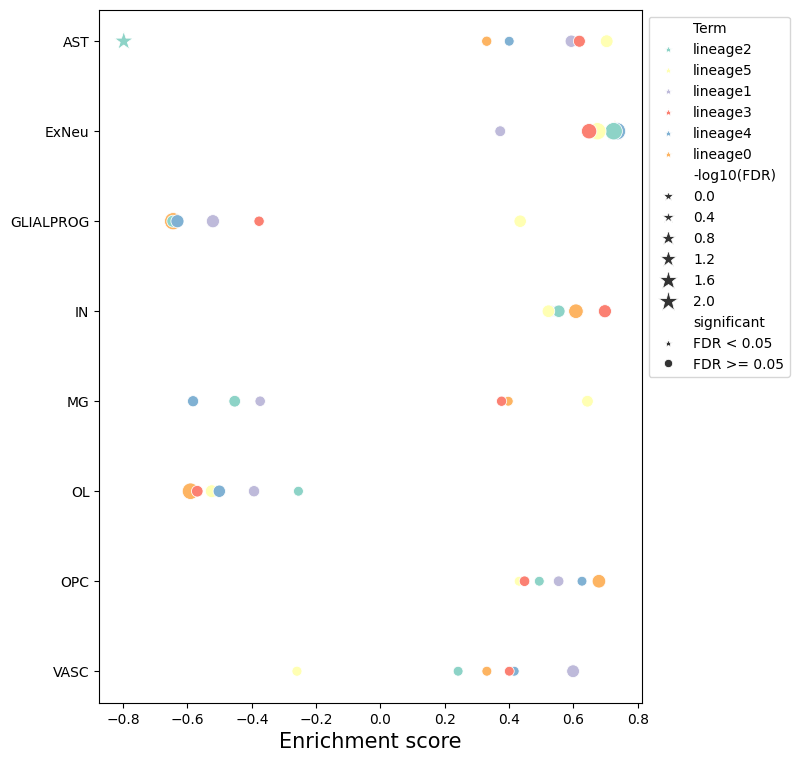

In [123]:
mpl.rcdefaults()
palette = sns.color_palette("Set3")

enrichment_plot(
    enrich_res=enrich_df,
    x='ES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='Term',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

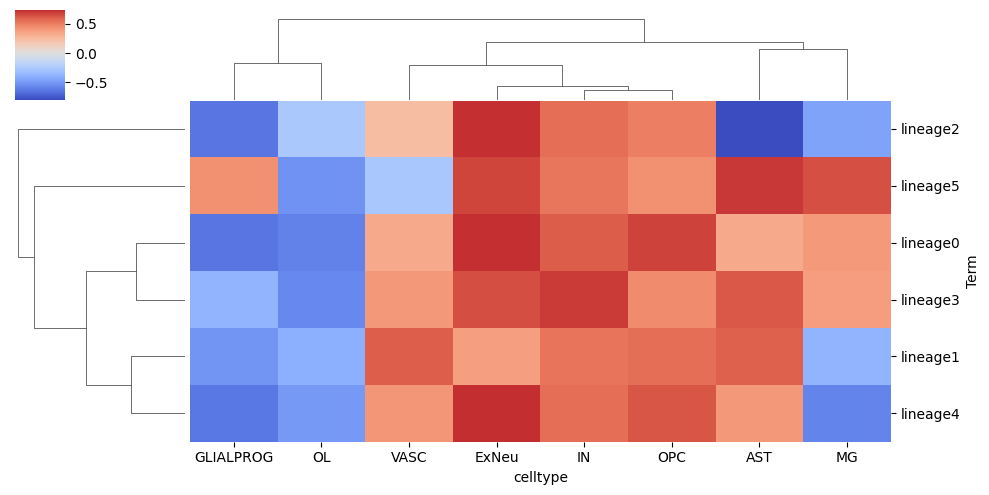

In [124]:
import seaborn as sns
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

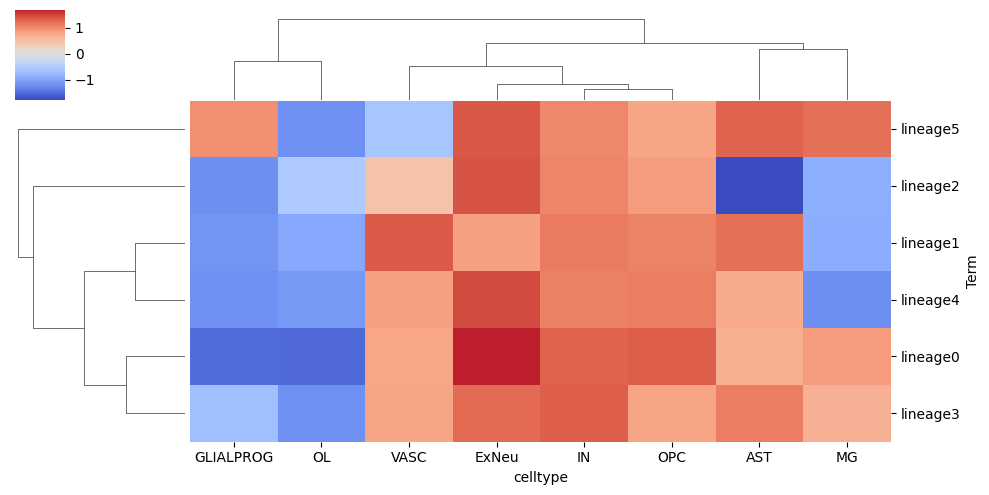

In [125]:
es_df = enrich_df.pivot(index='Term', columns='celltype', values='NES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

<Axes: xlabel='Term', ylabel='celltype'>

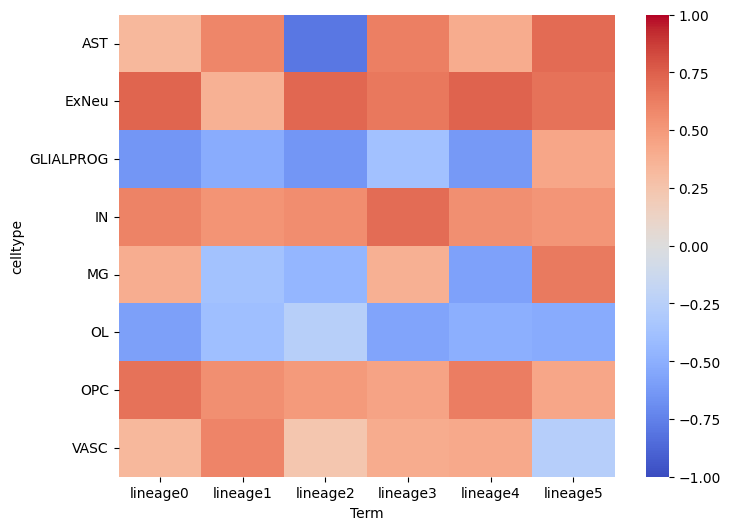

In [126]:
import seaborn as sns
fig = plt.figure(figsize=(8, 6))
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.heatmap(es_df.astype(float).T, cmap='coolwarm', center=0, vmin=-1, vmax=1)

### Gene visualization

Calculate average normalized expression

In [127]:
for lineage in gene_sets.keys():
    genes = scaled_adata.var_names.intersection(gene_sets[lineage])
    scaled_adata.obs[f'{lineage}_scaled'] = scaled_adata[:, genes].X.mean(axis=1)
scaled_adata.obs.head()

dataset    sample individual region  \
cell                                                                     
U01_AAACCTGAGGCGATAC-1_4350_BA9  Velmeshev  4350_BA9       4350    BA9   
U01_AAACCTGAGTACACCT-1_4350_BA9  Velmeshev  4350_BA9       4350    BA9   
U01_AAACCTGCAGCTGGCT-1_4350_BA9  Velmeshev  4350_BA9       4350    BA9   
U01_AAACCTGCAGTAGAGC-1_4350_BA9  Velmeshev  4350_BA9       4350    BA9   
U01_AAACCTGGTCTAAACC-1_4350_BA9  Velmeshev  4350_BA9       4350    BA9   

                                      age age(days)  age_range sex_original  \
cell                                                                          
U01_AAACCTGAGGCGATAC-1_4350_BA9  196 days     462.0  0-1 years         Male   
U01_AAACCTGAGTACACCT-1_4350_BA9  196 days     462.0  0-1 years         Male   
U01_AAACCTGCAGCTGGCT-1_4350_BA9  196 days     462.0  0-1 years         Male   
U01_AAACCTGCAGTAGAGC-1_4350_BA9  196 days     462.0  0-1 years         Male   
U01_AAACCTGGTCTAAACC-1_4350_BA9  196 days     462.0  0-1 years         Male   

                                region_broad chemistry  ...  \
cell                                                    ...   
U01_AAACCTGAGGCGATAC-1_4350_BA9           FC        V2  ...   
U01_AAACCTGAGTACACCT-1_4350_BA9           FC        V2  ...   
U01_AAACCTGCAGCTGGCT-1_4350_BA9           FC        V2  ...   
U01_AAACCTGCAGTAGAGC-1_4350_BA9           FC        V2  ...   
U01_AAACCTGGTCTAAACC-1_4350_BA9           FC        V2  ...   

                                age-specific_scaled maybe age-specific_scaled  \
cell                                                                            
U01_AAACCTGAGGCGATAC-1_4350_BA9            0.169778                  0.525614   
U01_AAACCTGAGTACACCT-1_4350_BA9           -0.289827                  0.303298   
U01_AAACCTGCAGCTGGCT-1_4350_BA9            0.172426                 -0.144213   
U01_AAACCTGCAGTAGAGC-1_4350_BA9            0.781447                  0.509838   
U01_AAACCTGGTCTAAACC-1_4350_BA9            0.215700                  0.214446   

                                maybe human-specific_scaled  \
cell                                                          
U01_AAACCTGAGGCGATAC-1_4350_BA9                    0.320317   
U01_AAACCTGAGTACACCT-1_4350_BA9                   -0.326632   
U01_AAACCTGCAGCTGGCT-1_4350_BA9                   -0.319896   
U01_AAACCTGCAGTAGAGC-1_4350_BA9                    0.324053   
U01_AAACCTGGTCTAAACC-1_4350_BA9                   -0.491317   

                                human-specific_scaled  lineage0_scaled  \
cell                                                                     
U01_AAACCTGAGGCGATAC-1_4350_BA9             -0.147600         0.358018   
U01_AAACCTGAGTACACCT-1_4350_BA9              0.195669        -0.126259   
U01_AAACCTGCAGCTGGCT-1_4350_BA9             -0.085273         0.166256   
U01_AAACCTGCAGTAGAGC-1_4350_BA9              0.099986         0.525426   
U01_AAACCTGGTCTAAACC-1_4350_BA9             -0.356485        -0.129245   

                                 lineage1_scaled  lineage2_scaled  \
cell                                                                
U01_AAACCTGAGGCGATAC-1_4350_BA9         0.040030        -0.181922   
U01_AAACCTGAGTACACCT-1_4350_BA9        -0.017521        -0.393413   
U01_AAACCTGCAGCTGGCT-1_4350_BA9        -0.238985        -0.117449   
U01_AAACCTGCAGTAGAGC-1_4350_BA9         0.482462         0.671906   
U01_AAACCTGGTCTAAACC-1_4350_BA9        -0.222533         0.433979   

                                 lineage3_scaled  lineage4_scaled  \
cell                                                                
U01_AAACCTGAGGCGATAC-1_4350_BA9         0.025824         0.854933   
U01_AAACCTGAGTACACCT-1_4350_BA9        -0.404438         0.582765   
U01_AAACCTGCAGCTGGCT-1_4350_BA9        -0.035916        -0.209554   
U01_AAACCTGCAGTAGAGC-1_4350_BA9         0.623637         0.735936   
U01_AAACCTGGTCTAAACC-1_4350_BA9         0.152099         0.153946   

                       

Vusualize

In [128]:
scaled_adata.obs.columns

Index(['dataset', 'sample', 'individual', 'region', 'age', 'age(days)',
       'age_range', 'sex_original', 'region_broad', 'chemistry', 'PMI', 'sex',
       'seurat_clusters', 'lineage', 'human_specific_scaled',
       'age-specific_scaled', 'maybe age-specific_scaled',
       'maybe human-specific_scaled', 'human-specific_scaled',
       'lineage0_scaled', 'lineage1_scaled', 'lineage2_scaled',
       'lineage3_scaled', 'lineage4_scaled', 'lineage5_scaled'],
      dtype='object')

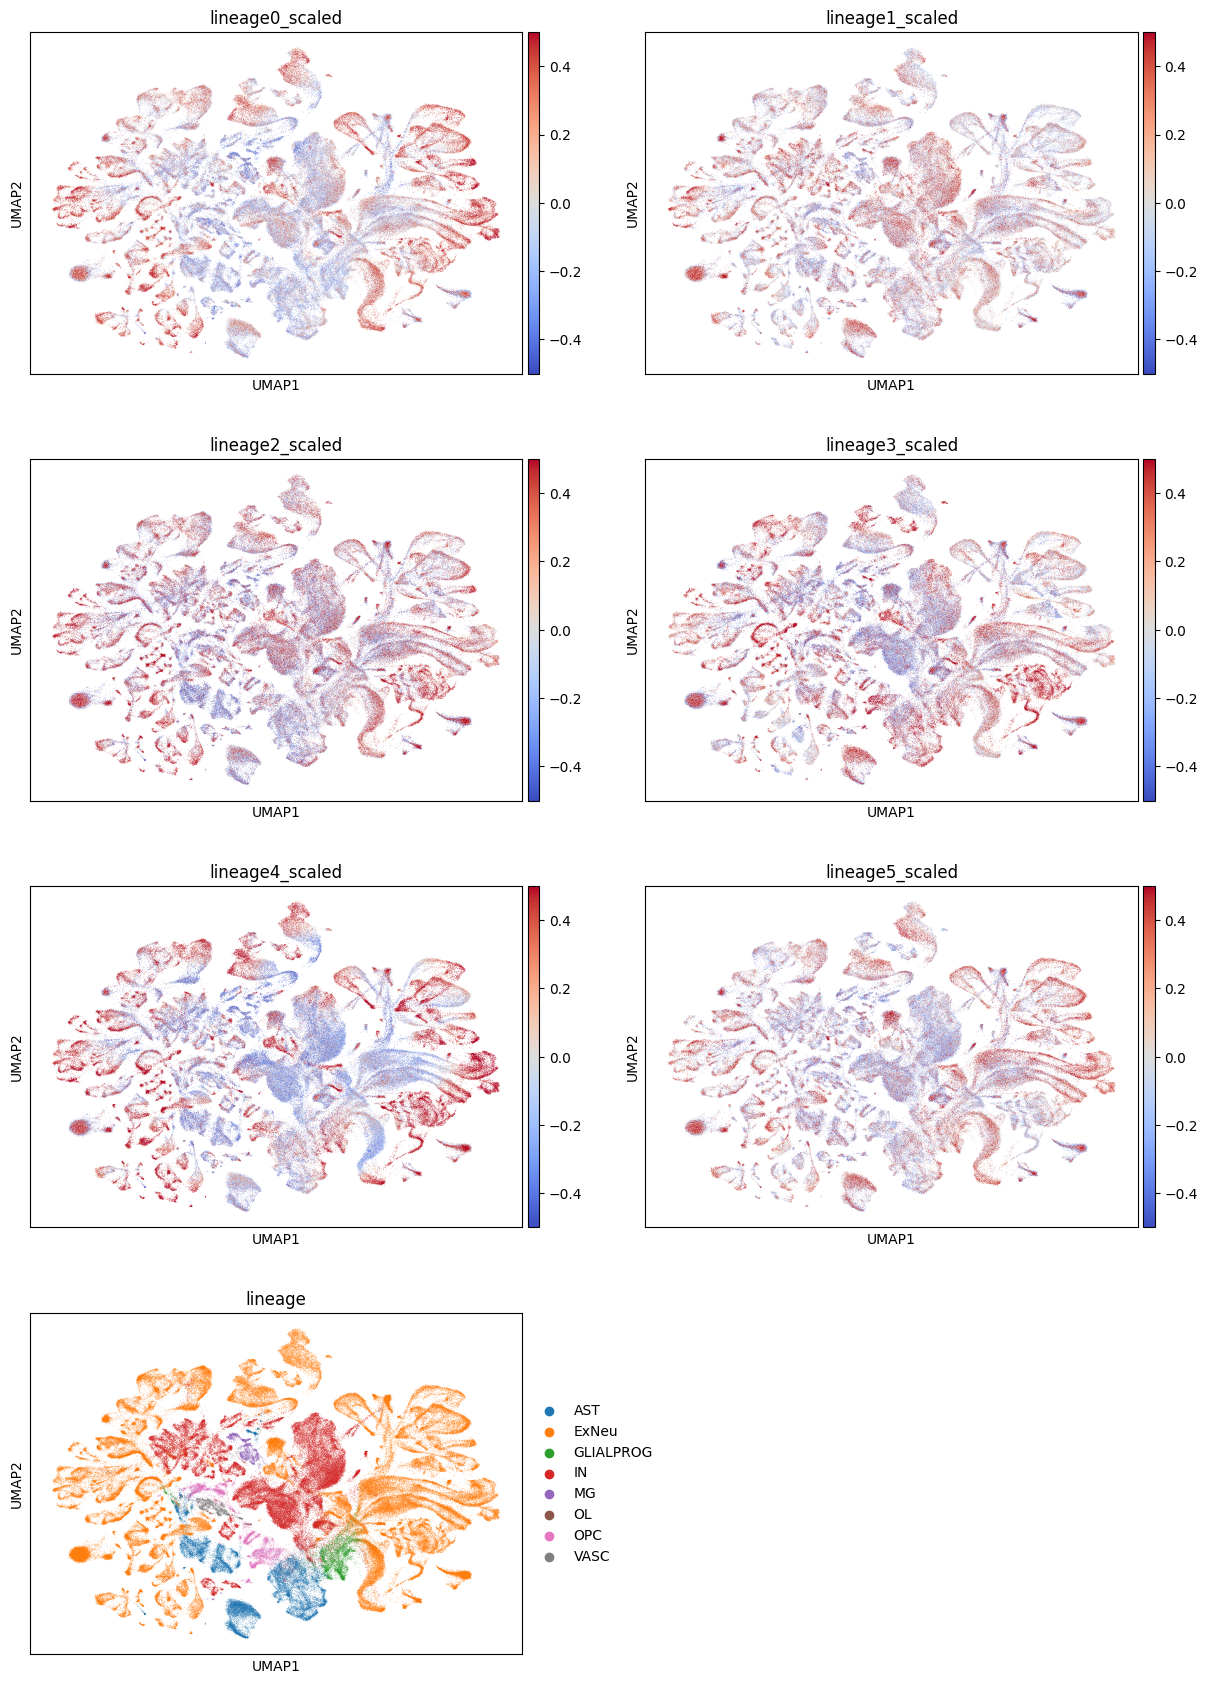

In [129]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmax=0.5, vmin=-0.5)
color = [
    'lineage0_scaled', 
    'lineage1_scaled',
    'lineage2_scaled', 
    'lineage3_scaled', 
    'lineage4_scaled',
    'lineage5_scaled', 
    'lineage'
    ]

sc.pl.umap(scaled_adata, color=color, cmap=cmap, norm=norm, ncols=2)

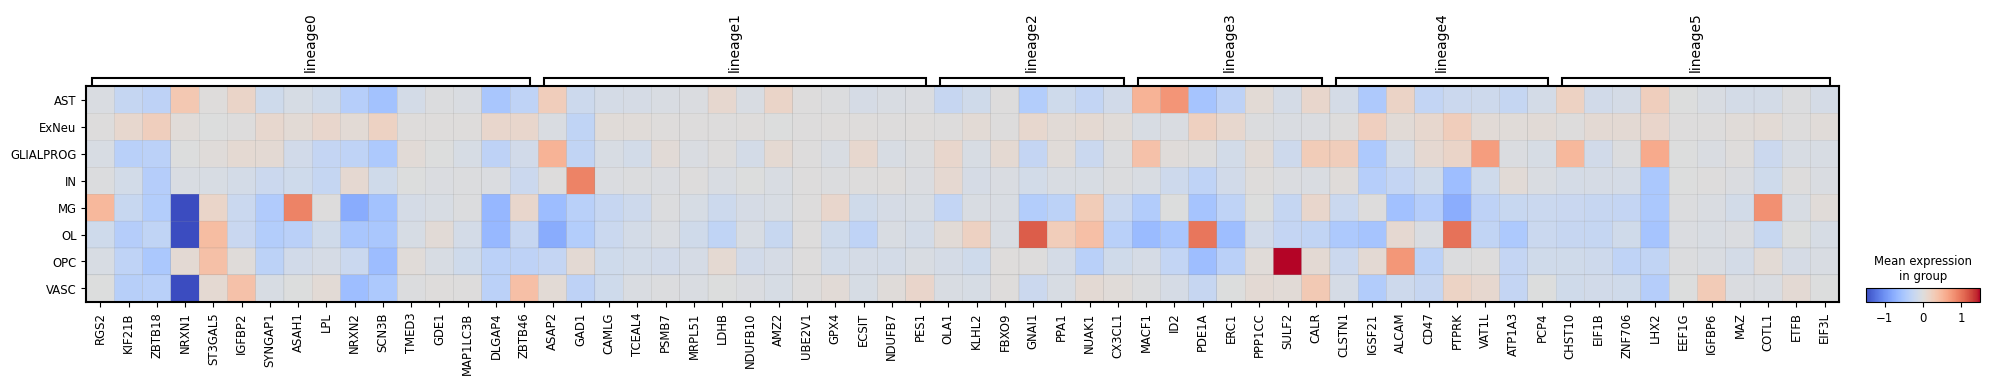

In [130]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmax=1.5, vmin=-1.5)
gene_sets_inter = {key: scaled_adata.var_names.intersection(value) for key, value in gene_sets.items()}

sc.pl.matrixplot(scaled_adata, gene_sets_inter, groupby='lineage', cmap='coolwarm', norm=norm)

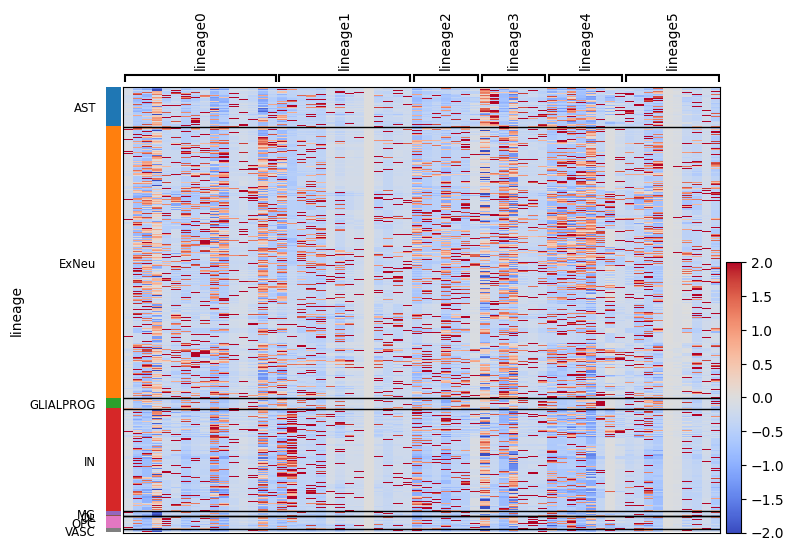

In [131]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmax=2, vmin=-2)
gene_sets_inter = {key: scaled_adata.var_names.intersection(value) for key, value in gene_sets.items()}

sc.pl.heatmap(scaled_adata, gene_sets_inter, groupby='lineage', cmap='coolwarm', norm=norm)

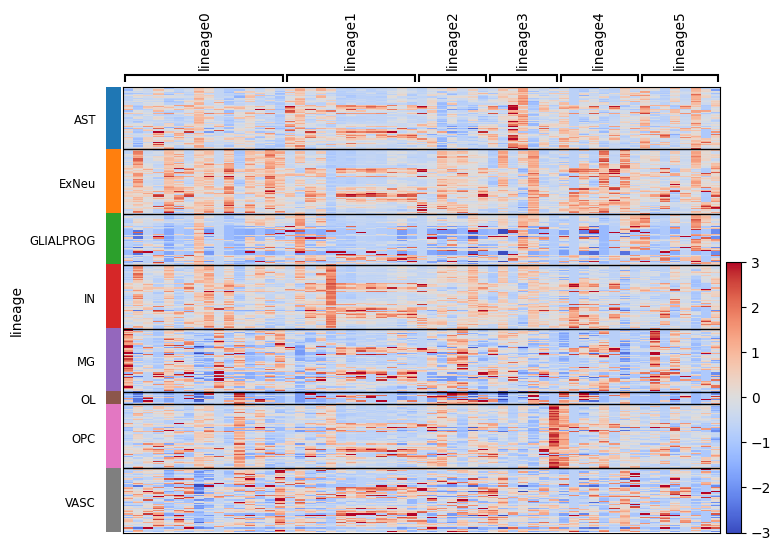

In [132]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0)
gene_sets_inter = {key: scaled_adata_pb.var_names.intersection(value) for key, value in gene_sets.items()}

sc.pl.heatmap(scaled_adata_pb, gene_sets_inter, groupby='lineage', cmap='coolwarm', vcenter=0, vmin=-3, vmax=3)

## Enrichment for chimp-specific genes

Create a dict with genesets

In [133]:
geneset = {'chimp-specific genes': chimp_specific_genes}

### T-test

Specify DE test

In [134]:
key = 't-test'

Run enrichment for genesets

In [135]:
enrich_df = enrich_celltypes(celltypes, geneset, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='score', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/8 [00:00<?, ?it/s]

2024-07-04 17:19:08,935 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:19:09,441 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:19:10,403 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:19:10,866 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:19:11,897 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:19:12,382 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  chimp-specific genes  0.561208  1.304088  0.175573  0.175573   
0  prerank  chimp-specific genes -0.439853 -1.075383  0.370909  0.370909   

  FWER p-val Tag % Gene %               Lead_genes celltype  
0      0.092  4/11  7.44%  SLC1A3;MASP1;BCL6;HTRA1      AST  
0   0.370909  2/11  1.10%             SLC1A3;HTRA1    ExNeu

Process enrichment results

In [136]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  chimp-specific genes  0.561208  1.304088  0.175573  0.175573   
0  prerank  chimp-specific genes -0.439853 -1.075383  0.370909  0.370909   

  FWER p-val Tag % Gene %               Lead_genes celltype  -log10(FDR)  \
0      0.092  4/11  7.44%  SLC1A3;MASP1;BCL6;HTRA1      AST     0.753077   
0   0.370909  2/11  1.10%             SLC1A3;HTRA1    ExNeu     0.429563   

  direction  significant  
0  enriched  FDR >= 0.05  
0  depleted  FDR >= 0.05

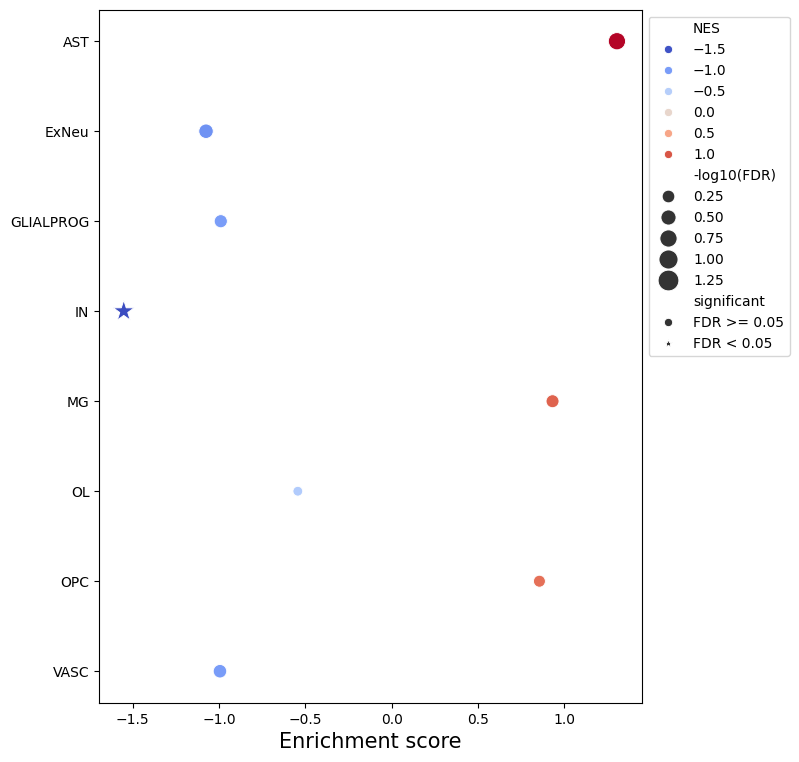

In [137]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='NES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

### Wilcoxon

Specify DE test

In [138]:
key = 'wilcoxon'

Run enrichment for genesets

In [139]:
enrich_df = enrich_celltypes(celltypes, geneset, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='lfc_product', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/8 [00:00<?, ?it/s]

2024-07-04 17:19:13,584 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:19:14,074 [WARNING] Duplicated values found in preranked stats: 0.04% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:19:14,543 [WARNING] Duplicated values found in preranked stats: 0.04% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:19:15,545 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:19:16,018 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  chimp-specific genes  0.669803  1.123659  0.344444  0.344444   
0  prerank  chimp-specific genes -0.610474 -1.183637   0.25419   0.25419   

  FWER p-val Tag % Gene %               Lead_genes celltype  
0      0.217  4/11  8.32%  SLC1A3;MASP1;BCL6;HTRA1      AST  
0    0.25419  2/11  0.90%             SLC1A3;HTRA1    ExNeu

Process enrichment results

In [140]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  chimp-specific genes  0.669803  1.123659  0.344444  0.344444   
0  prerank  chimp-specific genes -0.610474 -1.183637   0.25419   0.25419   

  FWER p-val Tag % Gene %               Lead_genes celltype  -log10(FDR)  \
0      0.217  4/11  8.32%  SLC1A3;MASP1;BCL6;HTRA1      AST     0.461622   
0    0.25419  2/11  0.90%             SLC1A3;HTRA1    ExNeu     0.593136   

  direction  significant  
0  enriched  FDR >= 0.05  
0  depleted  FDR >= 0.05

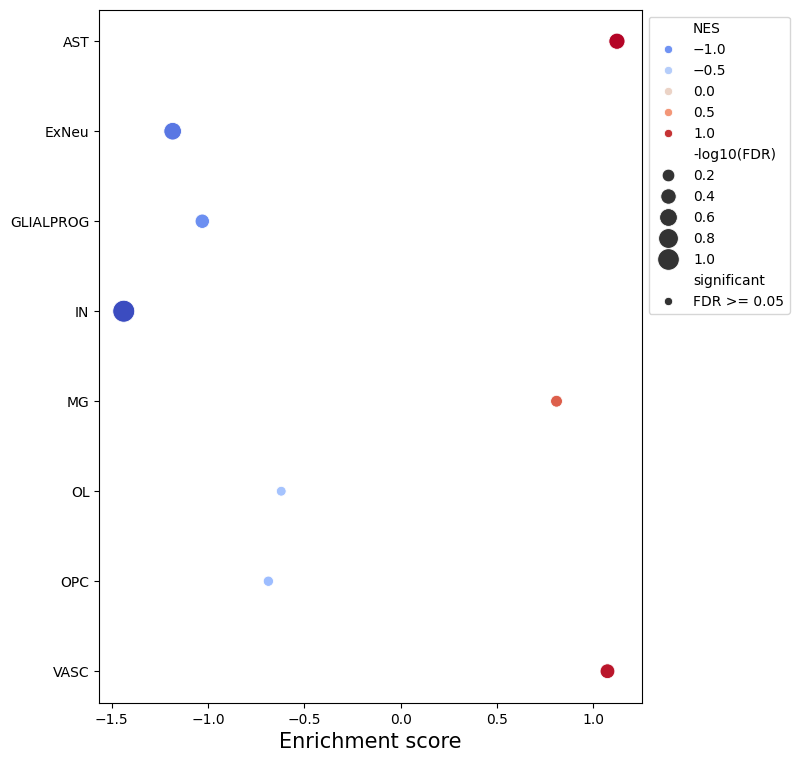

In [141]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='NES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

### Logreg

Specify DE test

In [142]:
key = 'logreg'

Run enrichment for genesets

In [143]:
enrich_df = enrich_celltypes(celltypes, geneset, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='score', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/8 [00:00<?, ?it/s]

2024-07-04 17:19:17,201 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:19:17,677 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:19:18,154 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:19:18,608 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:19:19,541 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  chimp-specific genes  0.525818  1.184453  0.274583  0.274583   
0  prerank  chimp-specific genes -0.451269 -0.990629   0.50566   0.50566   

  FWER p-val Tag %  Gene %            Lead_genes celltype  
0      0.148  3/11   3.46%     SLC1A3;BCL6;MASP1      AST  
0    0.50566  3/11  11.51%  SLC1A3;HTRA1;TPD52L1    ExNeu

Process enrichment results

In [144]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  chimp-specific genes  0.525818  1.184453  0.274583  0.274583   
0  prerank  chimp-specific genes -0.451269 -0.990629   0.50566   0.50566   

  FWER p-val Tag %  Gene %            Lead_genes celltype  -log10(FDR)  \
0      0.148  3/11   3.46%     SLC1A3;BCL6;MASP1      AST     0.559748   
0    0.50566  3/11  11.51%  SLC1A3;HTRA1;TPD52L1    ExNeu     0.295283   

  direction  significant  
0  enriched  FDR >= 0.05  
0  depleted  FDR >= 0.05

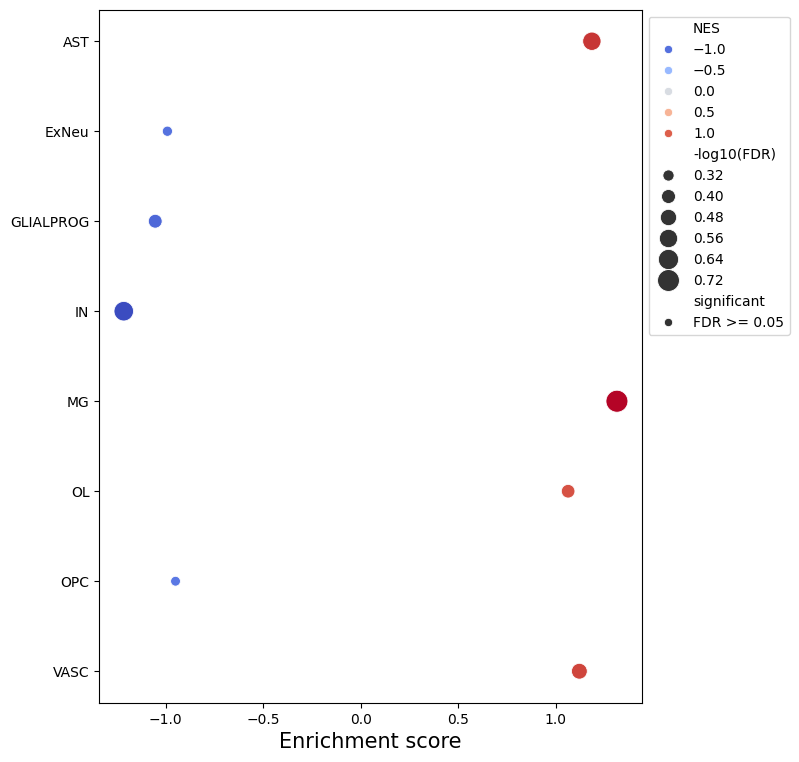

In [145]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='NES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

### EdgeR

Run enrichment for genesets

In [146]:
enrich_df = enrich_celltypes(res_edgeR, geneset, gene_col='names', score_col='score', method='score', gsea_kw={'verbose': True})
enrich_df.head(2)

  0%|          | 0/8 [00:00<?, ?it/s]

2024-07-04 17:19:21,206 [WARNING] Duplicated values found in preranked stats: 0.25% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:19:21,207 [INFO] Parsing data files for GSEA.............................
2024-07-04 17:19:21,211 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
2024-07-04 17:19:21,212 [INFO] 0001 gene_sets used for further statistical testing.....
2024-07-04 17:19:21,213 [INFO] Start to run GSEA...Might take a while..................
2024-07-04 17:19:21,961 [INFO] Congratulations. GSEApy runs successfully................

2024-07-04 17:19:21,977 [WARNING] Duplicated values found in preranked stats: 0.27% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-04 17:19:21,977 [INFO] Parsing data files for GSEA.............................
2024-07-04 17:19:21,977 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
20

Name                  Term        ES      NES NOM p-val FDR q-val  \
0  prerank  chimp-specific genes  0.673433  1.32988  0.066964  0.066964   
0  prerank  chimp-specific genes  0.344468  0.75508  0.838503  0.838503   

  FWER p-val Tag %  Gene %                    Lead_genes celltype  
0       0.06  5/12   6.80%  SLC1A3;MASP1;BCL6;HTRA1;BPTF      AST  
0      0.784  4/12  20.99%         ANK3;SEMA3A;ARF5;BPTF    ExNeu

Process enrichment results

In [147]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                  Term        ES      NES NOM p-val FDR q-val  \
0  prerank  chimp-specific genes  0.673433  1.32988  0.066964  0.066964   
0  prerank  chimp-specific genes  0.344468  0.75508  0.838503  0.838503   

  FWER p-val Tag %  Gene %                    Lead_genes celltype  \
0       0.06  5/12   6.80%  SLC1A3;MASP1;BCL6;HTRA1;BPTF      AST   
0      0.784  4/12  20.99%         ANK3;SEMA3A;ARF5;BPTF    ExNeu   

   -log10(FDR) direction  significant  
0     1.167719  enriched  FDR >= 0.05  
0     0.075978  enriched  FDR >= 0.05

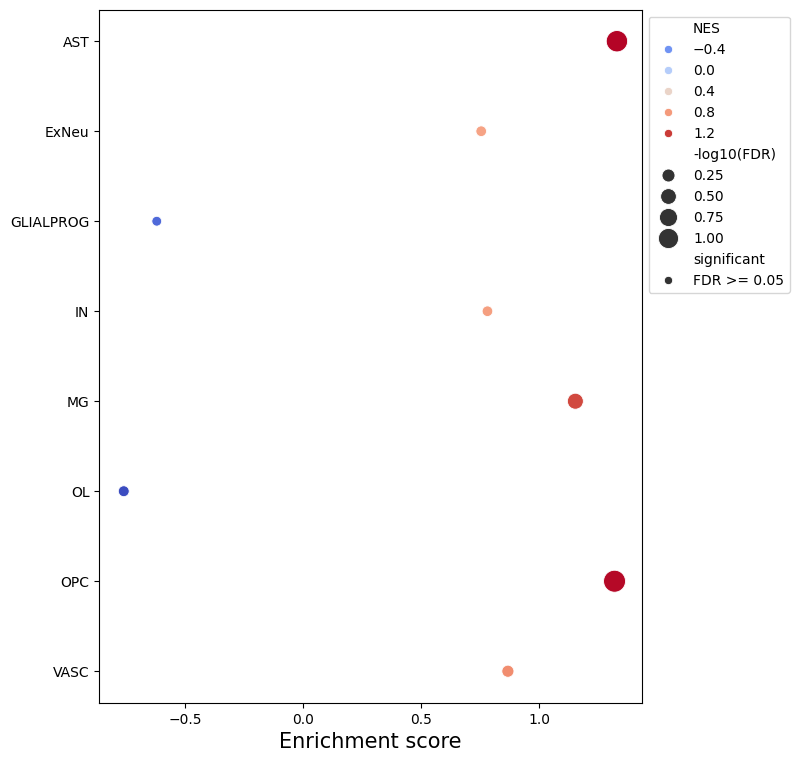

In [148]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='NES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

### Gene visualization

Calculate average normalized expression

In [149]:
genes = scaled_adata.var_names.intersection(chimp_specific_genes)
scaled_adata.obs[f'chimp_specific_scaled'] = scaled_adata[:, genes].X.mean(axis=1)
scaled_adata.obs.head()

dataset    sample individual region  \
cell                                                                     
U01_AAACCTGAGGCGATAC-1_4350_BA9  Velmeshev  4350_BA9       4350    BA9   
U01_AAACCTGAGTACACCT-1_4350_BA9  Velmeshev  4350_BA9       4350    BA9   
U01_AAACCTGCAGCTGGCT-1_4350_BA9  Velmeshev  4350_BA9       4350    BA9   
U01_AAACCTGCAGTAGAGC-1_4350_BA9  Velmeshev  4350_BA9       4350    BA9   
U01_AAACCTGGTCTAAACC-1_4350_BA9  Velmeshev  4350_BA9       4350    BA9   

                                      age age(days)  age_range sex_original  \
cell                                                                          
U01_AAACCTGAGGCGATAC-1_4350_BA9  196 days     462.0  0-1 years         Male   
U01_AAACCTGAGTACACCT-1_4350_BA9  196 days     462.0  0-1 years         Male   
U01_AAACCTGCAGCTGGCT-1_4350_BA9  196 days     462.0  0-1 years         Male   
U01_AAACCTGCAGTAGAGC-1_4350_BA9  196 days     462.0  0-1 years         Male   
U01_AAACCTGGTCTAAACC-1_4350_BA9  196 days     462.0  0-1 years         Male   

                                region_broad chemistry  ...  \
cell                                                    ...   
U01_AAACCTGAGGCGATAC-1_4350_BA9           FC        V2  ...   
U01_AAACCTGAGTACACCT-1_4350_BA9           FC        V2  ...   
U01_AAACCTGCAGCTGGCT-1_4350_BA9           FC        V2  ...   
U01_AAACCTGCAGTAGAGC-1_4350_BA9           FC        V2  ...   
U01_AAACCTGGTCTAAACC-1_4350_BA9           FC        V2  ...   

                                maybe age-specific_scaled  \
cell                                                        
U01_AAACCTGAGGCGATAC-1_4350_BA9                  0.525614   
U01_AAACCTGAGTACACCT-1_4350_BA9                  0.303298   
U01_AAACCTGCAGCTGGCT-1_4350_BA9                 -0.144213   
U01_AAACCTGCAGTAGAGC-1_4350_BA9                  0.509838   
U01_AAACCTGGTCTAAACC-1_4350_BA9                  0.214446   

                                maybe human-specific_scaled  \
cell                                                          
U01_AAACCTGAGGCGATAC-1_4350_BA9                    0.320317   
U01_AAACCTGAGTACACCT-1_4350_BA9                   -0.326632   
U01_AAACCTGCAGCTGGCT-1_4350_BA9                   -0.319896   
U01_AAACCTGCAGTAGAGC-1_4350_BA9                    0.324053   
U01_AAACCTGGTCTAAACC-1_4350_BA9                   -0.491317   

                                human-specific_scaled lineage0_scaled  \
cell                                                                    
U01_AAACCTGAGGCGATAC-1_4350_BA9             -0.147600        0.358018   
U01_AAACCTGAGTACACCT-1_4350_BA9              0.195669       -0.126259   
U01_AAACCTGCAGCTGGCT-1_4350_BA9             -0.085273        0.166256   
U01_AAACCTGCAGTAGAGC-1_4350_BA9              0.099986        0.525426   
U01_AAACCTGGTCTAAACC-1_4350_BA9             -0.356485       -0.129245   

                                 lineage1_scaled  lineage2_scaled  \
cell                                                                
U01_AAACCTGAGGCGATAC-1_4350_BA9         0.040030        -0.181922   
U01_AAACCTGAGTACACCT-1_4350_BA9        -0.017521        -0.393413   
U01_AAACCTGCAGCTGGCT-1_4350_BA9        -0.238985        -0.117449   
U01_AAACCTGCAGTAGAGC-1_4350_BA9         0.482462         0.671906   
U01_AAACCTGGTCTAAACC-1_4350_BA9        -0.222533         0.433979   

                                 lineage3_scaled  lineage4_scaled  \
cell                                                                
U01_AAACCTGAGGCGATAC-1_4350_BA9         0.025824         0.854933   
U01_AAACCTGAGTACACCT-1_4350_BA9        -0.404438         0.582765   
U01_AAACCTGCAGCTGGCT-1_4350_BA9        -0.035916        -0.209554   
U01_AAACCTGCAGTAGAGC-1_4350_BA9         0.623637         0.735936   
U01_AAACCTGGTCTAAACC-1_4350_BA9         0.152099         0.153946   

                                 lineage5_scaled  chimp_specific_scaled  
cell                                                                     
U01_AAACCTGAGGCGATAC-1

Vusualize

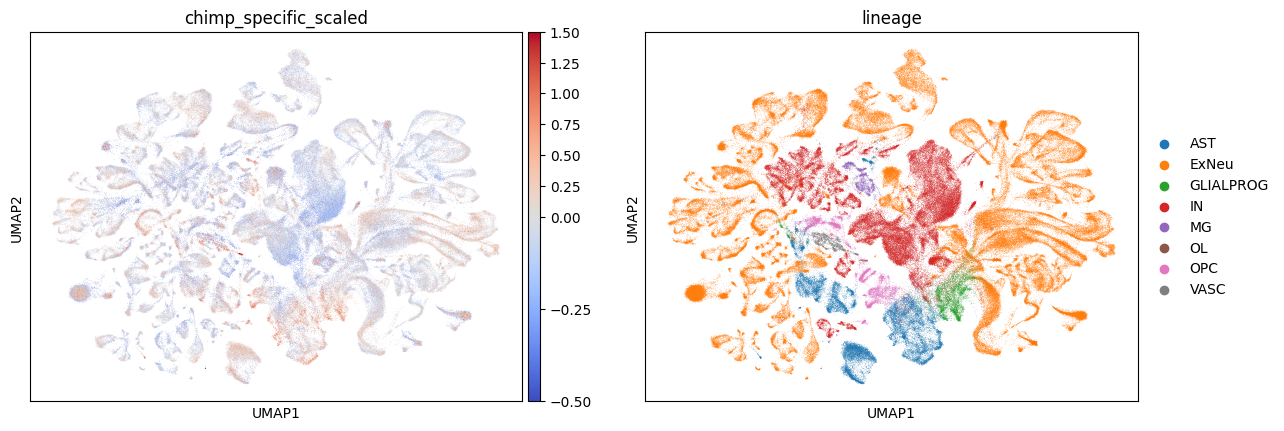

In [150]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmax=1.5, vmin=-0.5)

sc.pl.umap(scaled_adata, color=['chimp_specific_scaled', 'lineage'], cmap=cmap, norm=norm)

In [151]:
gene_sets = dict()
for label in chimp_cluster_groups.label.unique():
  gene_sets[f'lineage{label}'] = chimp_cluster_groups[chimp_cluster_groups.label == label].index.to_list()

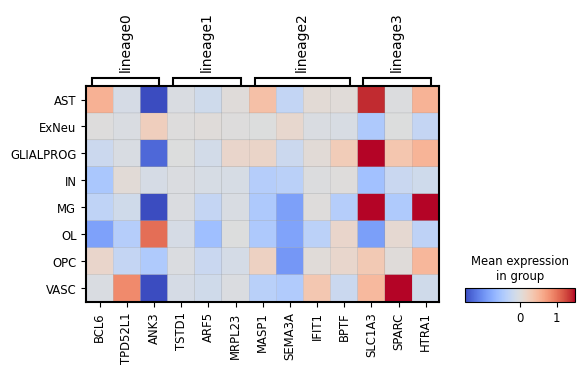

In [152]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmax=1.5, vmin=-1.5)
gene_sets_inter = {key: scaled_adata.var_names.intersection(value) for key, value in gene_sets.items()}

sc.pl.matrixplot(scaled_adata, gene_sets_inter, groupby='lineage', cmap='coolwarm', vcenter=0, vmin=-0.7, vmax=1.5)

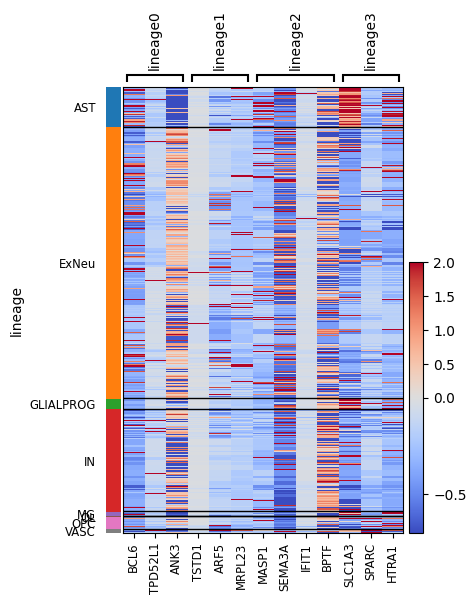

In [153]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmax=2, vmin=-2)
gene_sets_inter = {key: scaled_adata.var_names.intersection(value) for key, value in gene_sets.items()}

sc.pl.heatmap(scaled_adata, gene_sets_inter, groupby='lineage', cmap='coolwarm', vcenter=0, vmin=-0.7, vmax=2)

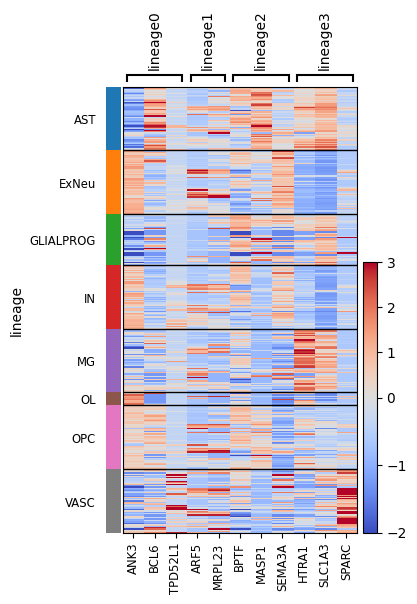

In [154]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0)
gene_sets_inter = {key: scaled_adata_pb.var_names.intersection(value) for key, value in gene_sets.items()}

sc.pl.heatmap(scaled_adata_pb, gene_sets_inter, groupby='lineage', cmap='coolwarm', vcenter=0, vmin=-2, vmax=3)